# Run SSA and weighted PCA on center-out (red and yellow, long delay) reaching data. Plot projections in pca and ssa dimensions

## Import packages

In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib
from scipy import io
import seaborn as sns
import time
from scipy.stats import pearsonr

from multiprocessing import Pool

# from ssa_functions import fit_ssa, get_sample_weights, weighted_pca, weighted_rrr
import sys
sys.path.append('/Users/sherryan/glaserlab/sca_analysis_parent/ssa')

from ssa import fit_ssa, weighted_pca
from ssa.util import get_sample_weights
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

sys.path.append('/Users/sherryan/glaserlab/sca_analysis_parent/dPCA')
from dPCA import dPCA


In [2]:
matplotlib.rc('font', size=18)

## Load Data

In [ ]:
# which monkey are we working with?
monkName = 'Balboa'

In [ ]:
# folder with rates
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'

# load data
data=io.loadmat(load_folder + monkName + '_outAndBack_redYellowConds_rawRates.mat')

# pull out the psths
# data is a C x N x T tensor 
data_array=data['data']

In [ ]:
data_array.shape

## Preprocess data


In [ ]:
#Downsample data (using a factor of 10 here)
data_downsamp=data_array[:,:,np.arange(0,data_array.shape[2],10)]

# pull out some useful numbers
numConds,numN,trlDur = np.shape(data_downsamp)

#Concatenate all the conditions (so the matrix is size N x TC instead of C x N x T)
data_concat=data_downsamp.swapaxes(0,1).reshape([data_downsamp.shape[1],data_downsamp.shape[0]*data_downsamp.shape[2]])

#fr range
fr_range=np.ptp(data_concat,axis=1)[:,None]

# make a time mask
timeMask = np.tile(np.arange(trlDur),(1,numConds)).T.flatten()

# define the times we want to use for ssa/pca
# target on: 20
# move on:   77
# return:    200
trainTimes = np.arange(20,230)

# define a 'training mask' for convenience 
trainMask = np.in1d(timeMask,trainTimes)

In [ ]:
#Subtract cross-condition mean
data_scm=data_downsamp-np.mean(data_downsamp,axis=0)[None,:,:]

#Concatenate all the conditions (so the matrix is size N x TC instead of C x N x T)
data_scm_concat=data_scm.swapaxes(0,1).reshape([data_downsamp.shape[1],data_downsamp.shape[0]*data_downsamp.shape[2]])

#Soft normalize (divide each neuron by its fr range + 5)
data_scm_norm=data_scm_concat/(fr_range+5)

# # mean-center the data (not needed in subtracted cross-condition mean)
# dMean = np.tile(np.mean(data_scm_norm,axis=1)[:,np.newaxis],(1,data_scm_norm.shape[1]))
# data_mc = data_scm_norm - dMean

In [ ]:
fit_data=np.copy(data_scm_norm.T) 
# how much to weight each timestep (used by)
sample_weights=get_sample_weights(fit_data)
fit_data_weighted = (fit_data * sample_weights)
fit_data_weighted.shape #CT*N

In [ ]:
data_nst_norm_w = fit_data_weighted.T.reshape([data_downsamp.shape[1],data_downsamp.shape[0], data_downsamp.shape[2]]) # data is a N x C x T tensor 
data_nst_norm_w.shape

data_nst_norm = fit_data.T.reshape([data_downsamp.shape[1],data_downsamp.shape[0], data_downsamp.shape[2]]) # data is a N x C x T tensor 


In [ ]:
trainT = np.arange(20,230)
trialT = np.arange(trlDur)
dpcaMask = np.in1d(trialT, trainT)

In [ ]:
R_est = 8
dpca = dPCA.dPCA(labels='st',n_components=R_est)
dpca.protect = ['t']
dpca.fit(data_nst_norm_w[:,:,dpcaMask])
dpca_latents = dpca.transform(data_nst_norm)

T = data_nst_norm.shape[2]
S = data_nst_norm.shape[1]

In [ ]:
dpca_order_var=np.argsort(-np.array(dpca.explained_variance_ratio_['st']))
dpca_order_var

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

dpca_proj = dpca_latents['st'][dpca_order_var[:8]].transpose(2,1,0)
R_est = 8

# g_cMap  = ['#00d01e', '#00ba22', '#00a426', '#008e2a', '#00782e', '#006232', '#004c36', '#00363a']
# g_cMap  = ['#e8a048', '#d48b3f', '#c07737', '#ac632e', '#984e26', '#843a1d', '#702615', '#5c120d']
dpca_cMap  = ['#0bffe0', '#0ae2c7', '#0ac6af', '#0aaa97', '#0a8d7e', '#0a7166', '#0a554e', '#0a3936']

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200
# range for y axis
yRange = [-1.8,1.8]
fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = dpca_proj[:,jj,ii], line = go.scatter.Line(color = dpca_cMap[jj],width = 1),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)
        if ii == (R_est-1):
            fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
            fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
            fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

            #
    # add a vertical line for scale
    scaleLine = go.Scatter(x = [-5, -5],y = [-0.4,0.4],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 3))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


fig.update_layout(height = 1000,width =500,title = 'dPCA ' + monkName,title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)


# save
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'
fig.write_image(figDir + monkName + 'dpca_' + str(R_est) + 'dims.pdf')
fig.show()


In [ ]:
# colorIdx = np.arange(0.55,1,0.4/8)
# dpca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.5)
# dpca_cMap = dpca_cMap(colorIdx)

# #Get indices of each trial
# T=data_downsamp.shape[2] #Length of time per condition
# trs=np.arange(0,8)
# t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]

# # define some useful time points
# tgt_idx=20
# move_idx=77
# ret_idx=200

# fig,ax=plt.subplots(R_est,1,figsize=(10,15))
# for i in range(R_est):
#     for j in range(len(trs)):

#         ax[i].plot(dpca_latents['st'][dpca_order_var[i],j] - np.mean(dpca_latents['st'][dpca_order_var[i]]) ,linewidth=2.25,color=dpca_cMap[j,:])
        
#         ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
#         ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
#         ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)
#         ax[i].plot([0,T],[0,0],'k--')

#         ax[i].set_xlim([0,T+1])
#         # ax[i].set_ylim([-2.5, 2.5])

#         if i<R_est-1:
#             ax[i].set_xticks([])
#         else:
#             ax[i].set_xlabel('Time (10ms bins)')
            
#         ax[i].set_yticks([])
#         ax[i].set_ylabel('Dim. '+str(i+1))

#     ax[0].set_title('dPCA Projections')

# # save
# # figDir = '/Users/sherryan//sca_analysis_parent/sca_analysis/original_fit/'
# # plt.savefig(figDir + monkName + '_dpcaProj_original_dim' + str(R_est) + '.pdf',dpi = 'figure')glaserlab

In [ ]:
time = np.arange(T)

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,dpca_latents['t'][0,s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,dpca_latents['s'][1,s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,dpca_latents['st'][0,s])
    
plt.title('1st mixing component')
plt.show()

## Fit SCA and PCA

In [ ]:
fit_data=np.copy(data_scm_norm.T) 
# how much to weight each timestep (used by)
sample_weights=get_sample_weights(fit_data)

# number of dimensions to find
R_est= 8

In [ ]:
fit_data.shape
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'
io.savemat(saveDir+ monkName + '_' + 'proc_neural_data.mat'
           , {'neuron_proc_activity': fit_data})

In [ ]:
model, latent, y_pred, losses = fit_ssa(X=fit_data[trainMask,:],R=R_est,sample_weight=sample_weights[trainMask],orth = False)
#Get the low dimensional representation
ssa_latent=fit_data@model.fc1.weight.detach().numpy().T+model.fc1.bias.detach().numpy()

#Plot the loss over all iterations
plt.figure()
plt.plot(losses)
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')

In [ ]:
#Plot the loss over the last 100 iterations (to see if it has truly hit a plateau)
plt.figure()
plt.plot(losses[-100:-1])
plt.xlabel('Training Epoch')
plt.ylabel('Loss')

In [ ]:
#Plot VT@V to see orthogonality of dimensions
product=model.fc2.weight.detach().numpy().T@model.fc2.weight.detach().numpy()
plt.imshow(product,clim=[-1,1],cmap='RdBu')
plt.colorbar()

In [ ]:
#Amount of squared activity each dimension explains in SSA
V_est_ssa=model.fc2.weight.detach().numpy()
infs_ssa=[np.sum((ssa_latent[:,i:i+1]@V_est_ssa[:,i:i+1].T)**2,axis=1) for i in range(R_est)]

cum_array_ssa_var=[np.sum(infs_ssa[i]) for i in range(R_est)]

#Order dimensions
ssa_order_var=np.argsort(-np.array(cum_array_ssa_var))

In [ ]:
#Save original SCA model weights
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
io.savemat(saveDir+ monkName + '_' + 'sca_original_dim' + str(R_est) + '.mat'
           , {'U': model.fc1.weight.detach().numpy().T, 'V': model.fc2.weight.detach().numpy().T
           , 'data': fit_data, 'U_bias': model.fc1.bias.detach().numpy(),'V_bias': model.fc2.bias.detach().numpy()
           , 'predictions':y_pred,'latents':ssa_latent})

In [ ]:
#Run weighted PCA for comparison
U_est_pca,V_est_pca = weighted_pca(fit_data[trainMask,:],R_est,sample_weights[trainMask])
pca_latent = fit_data@U_est_pca

In [ ]:
#Save original PCA model weights
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
io.savemat(saveDir+ monkName + '_' + 'pca_original_dim' + str(R_est) + '.mat'
           , {'U': U_est_pca, 'V': V_est_pca
           , 'data': fit_data, 'latents': pca_latent})

In [ ]:
#Amount of squared activity each dimension explains in PCA
infs_pca=[np.sum((pca_latent[:,i:i+1]@V_est_pca[i:i+1,:])**2,axis=1) for i in range(R_est)]

#Amount of squared activity each dimension explains in SSA
V_est_ssa=model.fc2.weight.detach().numpy()
infs_ssa=[np.sum((ssa_latent[:,i:i+1]@V_est_ssa[:,i:i+1].T)**2,axis=1) for i in range(R_est)]

cum_array_pca_var=[np.sum(infs_pca[i]) for i in range(R_est)]
cum_array_ssa_var=[np.sum(infs_ssa[i]) for i in range(R_est)]

#Order dimensions
pca_order_var=np.argsort(-np.array(cum_array_pca_var))
ssa_order_var=np.argsort(-np.array(cum_array_ssa_var))

In [ ]:
plt.figure(figsize=(15,5))
for i in range(R_est):
    
  
    # Plot SSA results
    plt.subplot(R_est,2,2*i+1)
    plt.plot(ssa_latent[:,ssa_order_var[i]])
    
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,2,2*i+2)
    plt.plot(pca_latent[:,pca_order_var[i]])
    
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        


plt.subplot(R_est,2,1)
plt.title('SCA LowD Projections')

plt.subplot(R_est,2,2)
plt.title('PCA LowD Projections')


In [ ]:
# fraction of colormap to use
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
ssa_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
ssa_cMap = ssa_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)


In [ ]:
#Get indices of each trial
T=data_downsamp.shape[2] #Length of time per condition
trs=np.arange(0,8)
t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200

# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'


fig,ax=plt.subplots(R_est,1,figsize=(10,15))
for i in range(R_est):
    for j in range(len(trs)):

        ax[i].plot(pca_latent[:,pca_order_var[i]][t_idxs[j]] - np.mean(pca_latent[:,pca_order_var[i]]),linewidth=2.25,color=pca_cMap[j,:])
        
        ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
        ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
        ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)

        ax[i].set_xlim([0,T+1])
        ax[i].set_ylim([-2.5, 2.5])
        ax[i].plot([0,T],[0,0],'k--')
        if i<R_est-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time (10ms bins)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('PCA Projections')

# # save figure

# save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'

# save
plt.savefig(figDir + monkName + '_pcaProj_original_dim' + str(R_est) + '.pdf',dpi = 'figure')

In [ ]:
#Get indices of each trial
T=data_downsamp.shape[2] #Length of time per condition
trs=np.arange(0,8)
t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]


fig,ax=plt.subplots(R_est,1,figsize=(10,15))
for i in range(R_est):
    for j in range(len(trs)):

        ax[i].plot(ssa_latent[:,ssa_order_var[i]][t_idxs[j]] - np.mean(ssa_latent[:,ssa_order_var[i]]),linewidth=2.25,color=ssa_cMap[j,:])
        
        ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
        ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
        ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)
        ax[i].plot([0,T],[0,0],'k--')

        ax[i].set_xlim([0,T+1])
        ax[i].set_ylim([-2.5, 2.5])

        if i<R_est-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time (10ms bins)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('SCA Projections')

# save
# plt.savefig(figDir + monkName + '_scaProj_original_dim' + str(R_est) + '.pdf',dpi = 'figure')

## PCA/SCA consistency in sub-sampled neurons

In [ ]:
R_est = 8
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
data=io.loadmat(load_folder + monkName + '_' + 'pca_original_dim'+str(R_est)+'.mat')
pca_original_latent = np.copy(data['latents'])
data=io.loadmat(load_folder + monkName + '_' + 'sca_original_dim'+str(R_est)+'.mat')
sca_original_latent = np.copy(data['latents'])

load_folder = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'
data = io.loadmat(load_folder+ monkName + '_proc_neural_data.mat')
fit_data = np.copy(data['neuron_proc_activity'])

In [ ]:
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/subsamps/'
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/subsamps/'
T=data_downsamp.shape[2] 
trs=np.arange(0,8)
t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]
# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200

def subsamps(n_samps, n_nrns_arr):
    dataL,numN = fit_data.shape #(2408, 124)
    sca_latents = np.zeros((dataL,R_est,len(n_nrns_arr),n_samps))
    pca_latents = np.zeros((dataL,R_est,len(n_nrns_arr),n_samps))
    neuron_samps = []
    sca_r = np.zeros((R_est,len(n_nrns_arr),n_samps))
    pca_r = np.zeros((R_est,len(n_nrns_arr),n_samps))
    neuron_index = []
    k=0
    for n_nrn in n_nrns_arr:
        nrn_samps = np.zeros((dataL,n_nrn,n_samps))
        nrn_index = np.zeros((n_nrn,n_samps))
        for n in range(n_samps):
            # draw 'numN' neurons with replacement
            nIdx = np.random.choice(numN,n_nrn,replace=False)      
            
            #save sampled neuron indices
            nrn_index[:,n] = nIdx
            
            #save sampled neuron pre-proceesed activity
            X_samp = fit_data[:,nIdx]
            nrn_samps[:,:,n] = X_samp
            
            # calculate our sample weights
            sWeights = get_sample_weights(X_samp)

            # run weighted pca
            pca_uEst, pca_vEst = weighted_pca(X_samp[trainMask,:],R_est,sWeights[trainMask])

            # pca latents
            pca_lat = X_samp @ pca_uEst

            #save pca rscore and latents
            pca_r_list = np.zeros((R_est,1))
            for i in range(R_est):
                a = np.array([abs(pearsonr(pca_lat[:,i], pca_original_latent[:,j])[0]) for j in range(R_est)])
                pca_r_list[i] = a.max()
            pca_r[:,k,n] = pca_r_list.ravel()
            pca_latents[:,:,k,n] = pca_lat
            
            # run sca
            m, lt, y, lo = fit_ssa(X=X_samp[trainMask,:],R=R_est,sample_weight=sWeights[trainMask],orth = False)
            #Get the low dimensional representation
            sca_lat=X_samp@m.fc1.weight.detach().numpy().T+m.fc1.bias.detach().numpy()

            #save sca rscore and latents
            sca_r_list = np.zeros((R_est,1))
            for i in range(R_est):
                a = np.array([abs(pearsonr(sca_lat[:,i], sca_original_latent[:,j])[0]) for j in range(R_est)])
                sca_r_list[i] = a.max()
            sca_r[:,k,n] = sca_r_list.ravel()
            sca_latents[:,:,k,n] = sca_lat
            
            if n < 1:
                #save pca and sca latent plots for first sample
                fig,ax=plt.subplots(R_est,1,figsize=(10,15))
                for i in range(R_est):
                    for j in range(len(trs)):

                        ax[i].plot(pca_lat[:,i][t_idxs[j]] - np.mean(pca_lat[:,i]),linewidth=2.25,color=pca_cMap[j,:])

                        ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
                        ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
                        ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)

                        ax[i].set_xlim([0,T+1])
                        # ax[i].set_ylim([-2.5, 2.5])
                        ax[i].plot([0,T],[0,0],'k--')
                        if i<R_est-1:
                            ax[i].set_xticks([])
                        else:
                            ax[i].set_xlabel('Time (10ms bins)')

                        ax[i].set_yticks([])
                        ax[i].set_ylabel('Dim. '+str(i+1))

                    ax[0].set_title('Weighted PCA')
                plt.savefig(figDir + monkName + '_pcaProj_ss' + str(n_nrn) + '.pdf',dpi = 'figure')
                plt.close()
                fig,ax=plt.subplots(R_est,1,figsize=(10,15))
                for i in range(R_est):
                    for j in range(len(trs)):

                        ax[i].plot(sca_lat[:,i][t_idxs[j]] - np.mean(sca_lat[:,i]),linewidth=2.25,color=ssa_cMap[j,:])

                        ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
                        ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
                        ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)
                        ax[i].plot([0,T],[0,0],'k--')

                        ax[i].set_xlim([0,T+1])
                        # ax[i].set_ylim([-2.5, 2.5])

                        if i<R_est-1:
                            ax[i].set_xticks([])
                        else:
                            ax[i].set_xlabel('Time (10ms bins)')

                        ax[i].set_yticks([])
                        ax[i].set_ylabel('Dim. '+str(i+1))

                    ax[0].set_title('SCA Projections')
                plt.savefig(figDir + monkName + '_scaProj_ss' + str(n_nrn) + '.pdf',dpi = 'figure')
                plt.close()
        k+=1
    #save results 
    io.savemat(saveDir+ monkName + '_' + 'subsamps'+ '_dim' + str(R_est) + '.mat'
           , {"ss_sca_latents": sca_latents, "ss_pca_latents": pca_latents
           , "ss_neuron_proc_activity": neuron_samps, "sca_absR": sca_r, "pca_absR": pca_r
           ,  "ss_neuron_index": neuron_index})
    
    return pca_r, sca_r

In [ ]:
n_nrns_arr = np.arange(40,101,20) #number of nrns, to draw the curve
n_samps = 10 #per data point, how many draws
pca_r, sca_r = subsamps(n_samps,n_nrns_arr)

In [ ]:
R_est = 24
n_samps = 10
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/subsamps/'
data=io.loadmat(load_folder + monkName + '_' + 'subsamps_dim'+str(R_est)+'.mat')
pca_r = data['pca_absR']
sca_r = data['sca_absR']

In [ ]:
zeros = np.zeros((24, 1, 10))
pca_r = np.concatenate((zeros, pca_r), axis=1)
sca_r = np.concatenate((zeros, sca_r), axis=1)

In [ ]:
pca_dist_samp_mean.shape

In [ ]:
pca_dist_dim_mean = np.mean(pca_r,axis=0)
sca_dist_dim_mean = np.mean(sca_r,axis=0)
pca_dist_samp_mean = np.mean(pca_dist_dim_mean,axis=1)
sca_dist_samp_mean = np.mean(sca_dist_dim_mean,axis=1)
plt.plot(np.arange(40,101,20), pca_dist_samp_mean[1:],label='PCA',color='k',lw=2)
plt.plot(np.arange(40,101,20), sca_dist_samp_mean[1:],label='SCA',color='purple',lw=2)
plt.scatter(np.tile(n_nrns_arr,(n_samps,1)).T,pca_dist_dim_mean,color='k')
plt.scatter(np.tile(n_nrns_arr,(n_samps,1)).T+2,sca_dist_dim_mean,color='purple')
plt.legend()
plt.ylabel('R')
plt.xlabel('# of neurons')
# plt.title('dim=8')
plt.ylim([0.4,1.02])
plt.tight_layout()
plt.savefig(figDir + monkName + '_subsamps_dim'+str(R_est)+'_r.pdf', dpi = 'figure')
# sca_r = np.zeros((R_est,len(n_nrns_arr),n_samps))
# plt.plot(pca_dist_mean[0],pca_dist_mean[1])

In [ ]:
sca_latents = data["ss_sca_latents"]
pca_latents = data["ss_pca_latents"]
std_sca_latents = np.std(sca_latents,axis=0)
std_pca_latents = np.std(pca_latents,axis=0)

In [ ]:
pca_dist_dim_mean = np.sum(pca_r * std_pca_latents, axis=0) / np.sum(std_pca_latents, axis=0)
sca_dist_dim_mean = np.sum(sca_r * std_sca_latents, axis=0) / np.sum(std_sca_latents, axis=0)
pca_dist_samp_mean = np.mean(pca_dist_dim_mean,axis=1)
sca_dist_samp_mean = np.mean(sca_dist_dim_mean,axis=1)
plt.plot(n_nrns_arr, pca_dist_samp_mean,label='PCA',color='k',lw=2)
plt.plot(n_nrns_arr, sca_dist_samp_mean,label='SCA',color='purple',lw=2)
plt.scatter(np.tile(n_nrns_arr,(n_samps,1)).T,pca_dist_dim_mean,color='k')
plt.scatter(np.tile(n_nrns_arr,(n_samps,1)).T+2,sca_dist_dim_mean,color='purple')
plt.legend()
plt.ylabel('Weighted R')
plt.xlabel('# of neurons')
plt.ylim([0.48,1.02])
plt.tight_layout()
plt.savefig(figDir + monkName + '_subsamps_dim'+str(R_est)+'_weighted_r.pdf', dpi = 'figure')

In [ ]:
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/subsamps/'
data=io.loadmat(load_folder + monkName + '_' + 'subsamps_dim8.mat')
n_nrns_arr = np.arange(20,101,20)
n_nrn_select = 20
idx = np.argwhere(n_nrns_arr == n_nrn_select)[0,0]
ssa_latent = data['ss_sca_latents'][:,:,idx,0]
pca_latent = data['ss_pca_latents'][:,:,idx,0]
pca_latent.shape

In [ ]:
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
data=io.loadmat(load_folder + monkName + '_' + 'pca_original_dim'+str(R_est)+'.mat')
pca_latent = np.copy(data['latents'])
data=io.loadmat(load_folder + monkName + '_' + 'sca_original_dim'+str(R_est)+'.mat')
ssa_latent = np.copy(data['latents'])

In [ ]:
# calculate across-condition variance of each projection as a function of time
R_est = 8
# reshape both latents to be size T x C x K 
rs_sca_latent = np.reshape(ssa_latent,(-1,8,R_est),order = 'F')

# calculate across condition variance
sca_var = np.var(rs_sca_latent,axis = 1)

# find peak occupancy of each dimension
pkIdx = np.argmax(sca_var,axis = 0)

# define plotting order
sca_order = np.argsort(pkIdx)

# resort ssa_latents by time of maximum occupancy
rs_sca_latent = rs_sca_latent[:,:,sca_order]

# do the same for the pca projections
rs_pca_latent = np.reshape(pca_latent,(-1,8,R_est),order = 'F')

pca_var = np.var(rs_pca_latent,axis = 1)
pkIdx = np.argmax(pca_var,axis = 0)
pca_order = np.argsort(pkIdx)
rs_pca_latent = rs_pca_latent[:,:,pca_order]

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# sca_cMap  = ['#5e0044', '#6f144e', '#812858', '#933c62', '#a5506d', '#b76477', '#c97881', '#db8c8c']
# sca_cMap = ['#56143f','#69164a','#7d1e55','#902c60','#a43c6b','#b64f75','#c8637c','#db7986']
# sca_cMap = ['#6c5f73','#76677b','#7e6e81','#877486','#8e7b8c','#968391','#9d8a95','#a4929b']
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)
pca_cMap = ['rgba({:.0f},{:.0f},{:.0f},{:.2f})'.format(r*255, g*255, b*255,a) for r, g, b, a in pca_cMap]

sca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
sca_cMap = sca_cMap(colorIdx)
sca_cMap = ['rgba({:.0f},{:.0f},{:.0f},{:.2f})'.format(r*255, g*255, b*255,a) for r, g, b, a in sca_cMap]

# range for y axis
yRange = [-0.8,0.8]

fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = rs_sca_latent[:,jj,ii], line = go.scatter.Line(color = sca_cMap[jj],width = 0.8),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)
        # if ii == (R_est-1):
        #     fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
        #     fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
        #     fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

            #
    # add a vertical line for scale
    scaleLine = go.Scatter(x = [0,0],y = [-0.2,0.2],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 1.5))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


fig.update_layout(height = 2000,width =600,title = 'SCA ' + monkName+' 20 nrns',title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
# fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
#                  ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [20,50,77,200],ticktext = ['200','500','770','2000'],visible = True,row = R_est,col = 1)


# save
fig.write_image(figDir + monkName + 'SCA_20nrn.pdf')
fig.show()


In [ ]:
# range for y axis
yRange = [-0.8,0.8]

fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = rs_pca_latent[:,jj,ii], line = go.scatter.Line(color = pca_cMap[jj],width = 0.8),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)
        # if ii == (R_est-1):
        #     fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
        #     fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
        #     fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

            #
    # add a vertical line for scale
    scaleLine = go.Scatter(x = [0,0],y = [-0.2,0.2],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 1.5))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


fig.update_layout(height = 2000,width =600,title = 'PCA ' + monkName+' 20 nrns',title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
# fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
#                  ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [20,50,77,200],ticktext = ['200','500','770','2000'],visible = True,row = R_est,col = 1)


# save
fig.write_image(figDir + monkName + 'PCA_20nrn.pdf')
fig.show()

## PCA/SCA dimension consistency in bootstrapping neurons

In [ ]:
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

In [ ]:
pca_original_latent = np.copy(pca_latent)
print(pca_original_latent.shape)

In [ ]:
sca_original_latent = np.copy(ssa_latent)
print(sca_original_latent.shape)

In [ ]:
#Color theme: red
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
ssa_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
ssa_cMap = ssa_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)


In [ ]:
data_array_copy = np.copy(data_array)
def bootstraps(n_boots):
    dataL,numN = fit_data.shape
    sca_latents = np.zeros((dataL,R_est,n_boots))
    pca_latents = np.zeros((dataL,R_est,n_boots))
    neuron_samps = np.zeros((dataL,numN,n_boots))
    sca_r = np.zeros((R_est,n_boots))
    pca_r = np.zeros((R_est,n_boots))
    neuron_index = np.zeros((numN,n_boots))

    for n in range(n_boots):
        # draw 'numN' neurons with replacement
        nIdx = np.random.choice(numN,numN)      
        
        #save sampled neuron indices
        neuron_index[:,n] = nIdx
        
        #save sampled neuron pre-proceesed activity
        X_samp = fit_data[:,nIdx]
        neuron_samps[:,:,n] = X_samp
        
        # calculate our sample weights
        sWeights = get_sample_weights(X_samp)

        # run weighted pca
        pca_uEst, pca_vEst = weighted_pca(X_samp[trainMask,:],R_est,sWeights[trainMask])

        # pca latents
        pca_lat = X_samp @ pca_uEst

        #save pca rscore and latents
        pca_r_list = np.zeros((R_est,1))
        for i in range(R_est):
            a = np.array([abs(pearsonr(pca_lat[:,i], pca_original_latent[:,j])[0]) for j in range(R_est)])
            pca_r_list[i] = a.max()
        pca_r[:,n] = pca_r_list.ravel()
        pca_latents[:,:,n] = pca_lat
        
        # run sca
        m, lt, y, lo = fit_ssa(X=X_samp[trainMask,:],R=R_est,sample_weight=sWeights[trainMask],orth = False)
        #Get the low dimensional representation
        sca_lat=X_samp@m.fc1.weight.detach().numpy().T+m.fc1.bias.detach().numpy()

        #save sca rscore and latents
        sca_r_list = np.zeros((R_est,1))
        for i in range(R_est):
            a = np.array([abs(pearsonr(sca_lat[:,i], sca_original_latent[:,j])[0]) for j in range(R_est)])
            sca_r_list[i] = a.max()
        sca_r[:,n] = sca_r_list.ravel()
        sca_latents[:,:,n] = sca_lat
        
        if n < 5:
            #save pca and sca latent plots for first 5 bootstraps
            fig,ax=plt.subplots(R_est,1,figsize=(10,15))
            for i in range(R_est):
                for j in range(len(trs)):

                    ax[i].plot(pca_lat[:,i][t_idxs[j]] - np.mean(pca_lat[:,i]),linewidth=2.25,color=pca_cMap[j,:])

                    ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
                    ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
                    ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)

                    ax[i].set_xlim([0,T+1])
                    ax[i].set_ylim([-2.5, 2.5])
                    ax[i].plot([0,T],[0,0],'k--')
                    if i<R_est-1:
                        ax[i].set_xticks([])
                    else:
                        ax[i].set_xlabel('Time (10ms bins)')

                    ax[i].set_yticks([])
                    ax[i].set_ylabel('Dim. '+str(i+1))

                ax[0].set_title('Weighted PCA')
            plt.savefig(figDir + monkName + '_pcaProj_bs' + str(n) + '.pdf',dpi = 'figure')
            plt.close()
            fig,ax=plt.subplots(R_est,1,figsize=(10,15))
            for i in range(R_est):
                for j in range(len(trs)):

                    ax[i].plot(sca_lat[:,i][t_idxs[j]] - np.mean(sca_lat[:,i]),linewidth=2.25,color=ssa_cMap[j,:])

                    ax[i].plot([tgt_idx,tgt_idx],[-1.7,1.7],'gray',linewidth=.5)
                    ax[i].plot([move_idx,move_idx],[-2,2],'k',linewidth=.5)
                    ax[i].plot([ret_idx,ret_idx],[-2,2],'k',linewidth=.5)
                    ax[i].plot([0,T],[0,0],'k--')

                    ax[i].set_xlim([0,T+1])
                    ax[i].set_ylim([-2.5, 2.5])

                    if i<R_est-1:
                        ax[i].set_xticks([])
                    else:
                        ax[i].set_xlabel('Time (10ms bins)')

                    ax[i].set_yticks([])
                    ax[i].set_ylabel('Dim. '+str(i+1))

                ax[0].set_title('SCA Projections')
            plt.savefig(figDir + monkName + '_scaProj_bs' + str(n) + '.png',dpi = 'figure')
            plt.close()
    #save bootstraping results for Gamal    
    io.savemat(saveDir+ monkName + '_' + 'bootstraps'+ '_' + str(n+1) + '_dim' + str(R_est) + '.mat'
           , {"bs_sca_latents": sca_latents, "bs_pca_latents": pca_latents
           , "bs_neuron_proc_activity": neuron_samps, "sca_absR": sca_r, "pca_absR": pca_r,
             "original_data": data_array_copy, "bs_neuron_index": neuron_index})
    
    return pca_r, sca_r

In [ ]:
#run bootstraps, get arrays of absolute Pearson's R's
numBoots = 100
pca_r, sca_r = bootstraps(numBoots)

In [ ]:
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
data=io.loadmat(load_folder + monkName + '_' + 'bootstraps_100_dim24.mat')
pca_r = data['pca_absR']
sca_r = data['sca_absR']

In [ ]:
#Color theme: blue
# define ssa colors
ssa_cMap = sns.cubehelix_palette(start = 2,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
ssa_cMap = ssa_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 2,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)# fraction of colormap to use


In [ ]:
pca_dist_mean = [np.mean(pca_r[:,i]) for i in range(pca_r.shape[1])]
sca_dist_mean = [np.mean(sca_r[:,i]) for i in range(sca_r.shape[1])]

In [ ]:
#plot bootstraping distribution of MEAN absolute Pearson's R for PCA and SCA
# plt.title("SCA/PCA mean abs(R), boots n=" + str(pca_r.shape[1]))
plt.hist(pca_dist_mean, bins=np.arange(.3, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'PCA') 
plt.hist(sca_dist_mean, bins=np.arange(.3, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
legend = plt.legend();
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
plt.xlabel('absolute Pearson R');
plt.ylabel('Frequency');
plt.tight_layout()
# save
plt.savefig(figDir + monkName + '_meanabs.pdf', dpi = 'figure')

In [ ]:
pca_dist_median = [np.median(pca_r[:,i]) for i in range(pca_r.shape[1])]
sca_dist_median = [np.median(sca_r[:,i]) for i in range(sca_r.shape[1])]

In [ ]:
#plot bootstraping distribution of MEDIAN absolute Pearson's R for PCA and SCA
# plt.title("SCA/PCA median abs(R), boots n=" + str(pca_r.shape[1]))
plt.hist(pca_dist_median, bins=np.arange(.3, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'PCA') 
plt.hist(sca_dist_median, bins=np.arange(.3, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
legend = plt.legend();
plt.xlabel('absolute Pearson R');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_medianabs.pdf', dpi = 'figure')

In [ ]:
#plot pairwise difference in MEAN absolute Pearson's R 
r2meanDiff_dist = [np.mean(sca_r[:,i])-np.mean(pca_r[:,i]) for i in range(pca_r.shape[1])]
# plt.title("SCA minus PCA mean abs(R), boots n=" + str(pca_r.shape[1]))
plt.hist(r2meanDiff_dist, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in r2meanDiff_dist if i > 0)/len(r2meanDiff_dist)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('absolute Pearson R difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_meanabsdiff.pdf', dpi = 'figure')

In [ ]:
#plot pairwise difference in MEDIAN absolute Pearson's R 
r2medianDiff_dist = [np.median(sca_r[:,i])-np.median(pca_r[:,i]) for i in range(pca_r.shape[1])]
# plt.title("SCA minus PCA median abs(R), boots n=" + str(pca_r.shape[1]))
plt.hist(r2medianDiff_dist, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in r2medianDiff_dist if i > 0)/len(r2medianDiff_dist)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('absolute Pearson R difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_medianabsdiff.pdf', dpi = 'figure')

In [ ]:
#Color theme: pink
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
ssa_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
ssa_cMap = ssa_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)


In [ ]:
#Calculate R^2
pca_r2 = np.square(pca_r)
sca_r2 = np.square(sca_r)

In [ ]:
s_pca_dist_mean = [np.mean(pca_r2[:,i]) for i in range(pca_r.shape[1])]
s_sca_dist_mean = [np.mean(sca_r2[:,i]) for i in range(sca_r.shape[1])]

In [ ]:
#plot bootstraping distribution of MEAN R^2 for PCA and SCA
# plt.title("SCA/PCA mean R^2, boots n=" + str(pca_r.shape[1]))
plt.hist(s_pca_dist_mean, bins=np.arange(0.1, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'PCA') 
plt.hist(s_sca_dist_mean, bins=np.arange(0.1, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
legend = plt.legend();
plt.xlabel('R^2');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_meanr2.pdf', dpi = 'figure')

In [ ]:
s_pca_dist_median = [np.median(pca_r2[:,i]) for i in range(pca_r.shape[1])]
s_sca_dist_median = [np.median(sca_r2[:,i]) for i in range(sca_r.shape[1])]

In [ ]:
#plot bootstraping distribution of MEDIAN R^2 for PCA and SCA
# plt.title("SCA/PCA median R^2, boots n=" + str(pca_r.shape[1]))
plt.hist(s_pca_dist_median, bins=np.arange(0.1, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'PCA') 
plt.hist(s_sca_dist_median, bins=np.arange(0.1, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
legend = plt.legend();
plt.xlabel('R^2');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_medianr2.pdf', dpi = 'figure')

In [ ]:
#plot pairwise difference in MEAN R^2
s_r2meanDiff_dist = [np.mean(sca_r2[:,i])-np.mean(pca_r2[:,i]) for i in range(pca_r.shape[1])]
# plt.title("SCA minus PCA mean R^2, boots n=" + str(pca_r.shape[1]))
plt.hist(s_r2meanDiff_dist, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in s_r2meanDiff_dist if i > 0)/len(s_r2meanDiff_dist)
plt.text(.3, 13, str(prop*100) +'%', style='italic')
plt.xlabel('R^2 difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_meanr2diff.pdf', dpi = 'figure')

In [ ]:
#plot pairwise difference in MEDIAN R^2
s_r2medianDiff_dist = [np.median(sca_r2[:,i])-np.median(pca_r2[:,i]) for i in range(pca_r.shape[1])]
# plt.title("SCA minus PCA median R^2, boots n=" + str(pca_r.shape[1]))
plt.hist(s_r2medianDiff_dist, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in s_r2medianDiff_dist if i > 0)/len(s_r2medianDiff_dist)
plt.text(.3, 13, str(prop*100) +'%', style='italic')
plt.xlabel('R^2 difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(figDir + monkName + '_medianr2diff.pdf', dpi = 'figure')

In [ ]:
# reshape pca reconstructions
pcaR = np.reshape(pca_r2,[-1,1],order = 'F')

# plot pca results with a small amount of jitter around 1
pcaLoc = np.random.normal(loc = 1,scale = 0.03,size = (numBoots*R_est,1))

# plot pca reconstractions across neurons and across bootstraps
plt.plot(pcaLoc,pcaR,'o',color = (0.4,0.4,0.4),ms = 4,alpha = 0.02);

# plot the mean and std of pca performance
plt.errorbar(1,np.mean(pcaR),np.std(pcaR),color = 'k',lw = 3,zorder = 3,label = 'PCA')
plt.plot(1,np.mean(pcaR),'o',color = 'k',ms = 8,zorder = 3);

# now SCA
scaR = np.reshape(sca_r2,[-1,1],order = 'F')

# get jittered position for ssa reconstructions
scaLoc = np.random.normal(loc = 2,scale = 0.03,size = (numBoots*R_est,1))
plt.plot(scaLoc,scaR,'o',color = 'darkblue',ms = 4, alpha = 0.02);

# plot the mean and std of ssa performance
plt.errorbar(2,np.mean(scaR),np.std(scaR) ,color = 'darkblue',lw = 3, zorder =3,label = 'SCA')
plt.plot(2,np.mean(scaR),'o',color = 'darkblue',ms = 8,zorder=3);

# clean up
plt.xlim((0.5, 2.5));plt.ylim((0,1));
plt.xticks(np.array([1,2]),('PCA','SSA'));
plt.yticks(np.array([0,0.5, 1]));
plt.ylabel('R^2');
# plt.title("")
legend = plt.legend(loc = 'lower right');
plt.tight_layout()
# # # save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

# # save
plt.savefig(figDir + monkName + '_Orig_r2_dist.pdf', dpi = 'figure')


## Test SCA explanatory power with Gamal projections

### Bootstraping

In [ ]:
# Load Gamal results in bootstraps
monkName = 'Alex'
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
gamal_data=io.loadmat(load_folder + monkName + '_bs_100_gamalLoadings.mat')

In [ ]:
# defind prep, move, and post projections
gamal_PrepProj = gamal_data['prepProj_list'][:,:,:,None]
gamal_MoveProj = gamal_data['moveProj_list'][:,:,:,None]
gamal_PostProj = gamal_data['postProj_list'][:,:,:,None]
print(gamal_PrepProj.shape)

In [ ]:
#Load PCA and SCA bootstrapping results
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
boot_data=io.loadmat(load_folder + monkName + '_bootstraps_100_dim8.mat')
print(boot_data.keys())

In [ ]:
sca_latents = boot_data['bs_sca_latents']
pca_latents = boot_data['bs_pca_latents']
print(pca_latents.shape)

In [ ]:
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
boot_data=io.loadmat(load_folder + monkName + '_bs_100_MIX_gamalLoadings.mat')
print(boot_data.keys())

In [ ]:
mix_gamal_latents = np.concatenate([boot_data['mixProj_list'][:,:4,:],boot_data['prepProj_list'][:,:4,:]],axis=1)
print(mix_gamal_latents.shape)

In [ ]:
R_est = 8

In [ ]:
### define some new colormaps
# fraction of colormap to use
colorIdx = np.arange(0.55,1,0.4/8)

# define prep colors
prep_cMap = sns.cubehelix_palette(start = 2,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
prep_cMap = prep_cMap(colorIdx)

# move colors
move_cMap = sns.cubehelix_palette(start = 2.35,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7)
move_cMap = move_cMap(colorIdx)

# posture colors
post_cMap = sns.cubehelix_palette(start = 2.8,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7)
post_cMap = post_cMap(colorIdx)

# plot colors
plt.figure(figsize = (5,5));
plt.subplot(311);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = prep_cMap[i,:],linewidth = 8);

plt.subplot(312);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = move_cMap[i,:],linewidth = 8);

plt.subplot(313);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = post_cMap[i,:],linewidth = 8);

# concatenate colormaps
prep_cMap = prep_cMap[:,:,None]
move_cMap = move_cMap[:,:,None]
post_cMap = post_cMap[:,:,None]

g_cMap = np.concatenate((prep_cMap, move_cMap, post_cMap),axis = 2)

In [ ]:
#plot Gamal projections for first 5 bootstraps
for n in range(5):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)

    #Get indices of each trial
    T=data_downsamp.shape[2] #Length of time per condition
    trs=np.arange(0,8)
    t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]

    # define some useful time points
    tgt_idx=20
    move_idx=77
    ret_idx=200

    # change color of axis labels so we can see them in the pdf
    plt.rcParams['text.color'] = 'k'
    plt.rcParams['xtick.color'] = 'k'
    plt.rcParams['ytick.color'] = 'k'
    plt.rcParams['axes.labelcolor'] = 'k'

    fig,ax=plt.subplots(12,3,figsize=(15,20))
    for E in range(3):

        for i in range(12):
            for j in range(len(trs)):

                ax[i,E].plot(gProj[:,i,E][t_idxs[j]],linewidth=2.25,color=g_cMap[j,:,E])

                ax[i,E].plot([tgt_idx,tgt_idx],[-100,100],'gray',linewidth=.5)
                ax[i,E].plot([move_idx,move_idx],[-100,100],'k',linewidth=.5)
                ax[i,E].plot([ret_idx,ret_idx],[-100,100],'k',linewidth=.5)

                ax[i,E].set_xlim([0,T+1])
                ax[i,E].set_ylim([-2, 2])

                if i<12-1:
                    ax[i,E].set_xticks([])
                else:
                    ax[i,E].set_xlabel('Time (10ms bins)')

                ax[i,E].set_yticks([])
                ax[i,E].set_ylabel('Dim. '+str(i+1))

    ax[0,0].set_title('Preparation Projections')
    ax[0,1].set_title('Move Projections')
    ax[0,2].set_title('Posture Projections')
    # save figure

    # save directory
    figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

    # save
    plt.savefig(figDir + monkName + '_bs' +  str(n) + '_gamalProj.pdf',dpi = 'figure')

In [ ]:
## IND BEHAV

# number of bootstraps
numBoots = gamal_PrepProj.shape[2]

# initialize vector to hold R2
# each -1 dimenision corresponds to the reconstruction R2 from the prep, move, or posture projections
# allR2_pca = np.zeros((numBoots,R_est,3))
allR2_mgamal = np.zeros((numBoots,R_est,3))
allR2_sca = np.zeros((numBoots,R_est,3))

# cycle through bootstrap repetitions
for n in range(numBoots):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)

    # # pull out PCA bootstrap latents
    # Y = pca_latents[:,:,n]

    # # get B (regression weights) from prep, move, and posture projections
    # for e in np.arange(3):

    #     # make life a bit easier and just pull out the gamal projections we want
    #     X = gProj[:,:,e]

    #     # regress
    #     B = np.linalg.inv(X.T@X) @ X.T @ Y

    #     # reconstruct Y 
    #     Y_hat = X @ B
    
    #     # calculate R2
    #     ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    #     ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    #     allR2_pca[n,:,e] = 1 - (ss_res/ss_tot)

    # pull out Mixed Gamal bootstrap latents
    Y = mix_gamal_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
    
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_mgamal[n,:,e] = 1 - (ss_res/ss_tot)        

    # pull out SCA bootstrap latents
    Y = sca_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
 
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_sca[n,:,e] = 1 - (ss_res/ss_tot)

# take max R2 for each dimension 
maxR2_mgamal = np.max(allR2_mgamal,axis = 2)
maxR2_sca = np.max(allR2_sca,axis = 2)

#print first bootstrap's max R2's
print(maxR2_mgamal[0])
print(maxR2_sca[0])

In [ ]:
# ALL BEHAV

# number of bootstraps
numBoots = gamal_PrepProj.shape[2]

# initialize vector to hold R2
# allR2_pca = np.zeros((numBoots,R_est))
allR2_mgamal = np.zeros((numBoots,R_est))
allR2_sca = np.zeros((numBoots,R_est))

# cycle through bootstrap repetitions
for n in range(numBoots):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)
    gProj = gProj.reshape(gProj.shape[0],-1)
    # # pull out PCA bootstrap latents
    # Y = pca_latents[:,:,n]

    # # pull out all gamal projections
    # X = gProj

    # # regress
    # B = np.linalg.inv(X.T@X) @ X.T @ Y

    # # reconstruct Y 
    # Y_hat = X @ B

    # # calculate R2
    # ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    # ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    # allR2_pca[n,:] = 1 - (ss_res/ss_tot)

    # pull out mixed gamal bootstrap latents
    Y = mix_gamal_latents[:,:,n]

    # pull out all gamal projections
    X = gProj

    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y

    # reconstruct Y 
    Y_hat = X @ B

    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_mgamal[n,:] = 1 - (ss_res/ss_tot)

    # pull out SCA bootstrap latents
    Y = sca_latents[:,:,n]

    # pull out all gamal projections
    X = gProj

    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y

    # reconstruct Y 
    Y_hat = X @ B

    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_sca[n,:] = 1 - (ss_res/ss_tot)

#print first bootstrap's max R2's
print(allR2_mgamal[0])
print(allR2_sca[0])

In [ ]:
# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

# reshape pca reconstructions
pcaR2_recon = np.reshape(maxR2_mgamal,[-1,1],order = 'F')

# plot pca results with a small amount of jitter around 1
pcaLoc = np.random.normal(loc = 1,scale = 0.03,size = (numBoots*R_est,1))

# plot pca reconstractions across neurons and across bootstraps
plt.plot(pcaLoc,pcaR2_recon,'o',color = (0.4,0.4,0.4),ms = 4,alpha = 0.02);

# plot the mean and std of pca performance
plt.errorbar(1,np.mean(pcaR2_recon),np.std(pcaR2_recon),color = 'k',lw = 3,zorder = 3,label = 'PCA')
plt.plot(1,np.mean(pcaR2_recon),'o',color = 'k',ms = 8,zorder = 3);

# now SCA
scaR2_recon = np.reshape(maxR2_sca,[-1,1],order = 'F')

# get jittered position for ssa reconstructions
scaLoc = np.random.normal(loc = 2,scale = 0.03,size = (numBoots*R_est,1))
plt.plot(scaLoc,scaR2_recon,'o',color = 'purple',ms = 4, alpha = 0.02);

# plot the mean and std of ssa performance
plt.errorbar(2,np.mean(scaR2_recon),np.std(scaR2_recon) ,color = 'purple',lw = 3, zorder =3,label = 'SCA')
plt.plot(2,np.mean(scaR2_recon),'o',color = 'purple',ms = 8,zorder=3);

# clean up
plt.xlim((0.5, 2.5));plt.ylim((0,1));
plt.xticks(np.array([1,2]),('Mixed Gamal','SCA'));
plt.yticks(np.array([0,0.5, 1]));
plt.ylabel('R2');
plt.tight_layout()
legend = plt.legend(loc = 'lower right');

# # # save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

# # save
plt.savefig(figDir + monkName + '_mix_gamal_r2_dist_ind.pdf', dpi = 'figure')


In [ ]:
# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

# reshape pca reconstructions
pcaR2_recon = np.reshape(allR2_mgamal,[-1,1],order = 'F')

# plot pca results with a small amount of jitter around 1
pcaLoc = np.random.normal(loc = 1,scale = 0.03,size = (numBoots*R_est,1))
fig, ax = plt.subplots()
# plot pca reconstractions across neurons and across bootstraps
plt.plot(pcaLoc,pcaR2_recon,'o',color = (0.4,0.4,0.4),ms = 4,alpha = 0.02);

# plot the mean and std of pca performance
plt.errorbar(1,np.mean(pcaR2_recon),np.std(pcaR2_recon), uplims=1,color = 'k',lw = 3,zorder = 3,label = 'PCA')
plt.plot(1,np.mean(pcaR2_recon),'o',color = 'k',ms = 8,zorder = 3);

# now SCA
scaR2_recon = np.reshape(allR2_sca,[-1,1],order = 'F')

# get jittered position for ssa reconstructions
scaLoc = np.random.normal(loc = 2,scale = 0.03,size = (numBoots*R_est,1))
plt.plot(scaLoc,scaR2_recon,'o',color = 'purple',ms = 4, alpha = 0.02);

# plot the mean and std of ssa performance
plt.errorbar(2,np.mean(scaR2_recon),np.std(scaR2_recon), uplims=1, color = 'purple',lw = 3, zorder =3,label = 'SCA')
plt.plot(2,np.mean(scaR2_recon),'o',color = 'purple',ms = 8,zorder=3);

# clean up
plt.xlim((0.5, 2.5));plt.ylim((0,1.05));
plt.xticks(np.array([1,2]),('Mixed Gamal','SSA'));
plt.yticks(np.array([0,0.5, 1]));
plt.ylabel('R2');
plt.tight_layout()
legend = plt.legend(loc = 'lower right');

# # # save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

# # save
plt.savefig(figDir + monkName + '_mix_gamal_r2_dist_all.pdf', dpi ='figure')


In [ ]:
# Color theme: purple
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
ssa_cMap = sns.cubehelix_palette(rot = 0.2,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
ssa_cMap = ssa_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(rot = 0.2,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)

In [ ]:
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
#plot bootstraping distribution of MEAN R2
# plt.title("Gamal - SCA/PCA mean R2, boots n=" + str(100))
plt.hist(np.mean(maxR2_mgamal, axis = 1), bins=np.arange(0.5, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'Mixed Gamal') 
plt.hist(np.mean(maxR2_sca, axis = 1), bins=np.arange(0.5, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
# add a legend
legend = plt.legend();
plt.xlabel('R2');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_meanr2.pdf', dpi = 'figure')

In [ ]:
#plot bootstraping distribution of MEDIAN R2
# plt.title("Gamal - SCA/PCA median R2, boots n=" + str(100))
plt.hist(np.median(maxR2_mgamal, axis = 1), bins=np.arange(0.5, 1.05, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'Mixed Gamal') 
plt.hist(np.median(maxR2_sca, axis = 1), bins=np.arange(0.5, 1.05, 0.05),color=ssa_cMap[0,:],alpha = .7,label = 'SCA') 
plt.xlabel('R2');
plt.ylabel('Frequency');
# add a legend
legend = plt.legend();
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_medianr2.pdf', dpi = 'figure')

In [ ]:
gamal_allspec_r2meanDiff_sca = [np.mean(allR2_sca[i,:])-np.mean(maxR2_sca[i,:]) for i in range(100)]
gamal_allspec_r2meanDiff_pca = [np.mean(allR2_mgamal[i,:])-np.mean(maxR2_mgamal[i,:]) for i in range(100)]
pca_sca_diff = np.array(gamal_allspec_r2meanDiff_pca) - np.array(gamal_allspec_r2meanDiff_sca)

# plt.title("Gamal - SCA minus PCA mean R2, boots n=" + str(100))
plt.hist(gamal_allspec_r2meanDiff_sca, bins=np.arange(-0.5, 0.55, 0.05),color=ssa_cMap[0,:],alpha = .7, label = 'SCA')
plt.hist(gamal_allspec_r2meanDiff_pca, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'Mixed Gamal')
plt.legend()
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in pca_sca_diff if i > 0)/len(pca_sca_diff)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('R2 difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_allMeanDiff.pdf', dpi = 'figure')

In [ ]:
gamal_allspec_r2medianDiff_sca = [np.median(allR2_sca[i,:])-np.median(maxR2_sca[i,:]) for i in range(100)]
gamal_allspec_r2medianDiff_pca = [np.median(allR2_mgamal[i,:])-np.median(maxR2_mgamal[i,:]) for i in range(100)]
pca_sca_diff = np.array(gamal_allspec_r2medianDiff_pca) - np.array(gamal_allspec_r2medianDiff_sca)

# plt.title("Gamal - SCA minus PCA mean R2, boots n=" + str(100))
plt.hist(gamal_allspec_r2medianDiff_sca, bins=np.arange(-0.5, 0.55, 0.05),color=ssa_cMap[0,:],alpha = .7, label = 'SCA')
plt.hist(gamal_allspec_r2medianDiff_pca, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7, label = 'Mixed Gamal')
plt.legend()
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in pca_sca_diff if i > 0)/len(pca_sca_diff)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('R2 difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_allMedianDiff.pdf', dpi = 'figure')

In [ ]:
#plot SCA/PCA difference in MEAN R2
gamal_r2meanDiff = [np.mean(maxR2_sca[i,:])-np.mean(maxR2_mgamal[i,:]) for i in range(100)]
# plt.title("Gamal - SCA minus PCA mean R2, boots n=" + str(100))
plt.hist(gamal_r2meanDiff, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in gamal_r2meanDiff if i > 0)/len(gamal_r2meanDiff)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('R2 difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_meanr2diff.pdf', dpi = 'figure')

In [ ]:
#plot SCA/PCA difference in MEDIAN R2
gamal_r2medianDiff = [np.median(maxR2_sca[i,:])-np.median(maxR2_mgamal[i,:]) for i in range(100)]
# plt.title("Gamal - SCA minus PCA median R2, boots n=" + str(100))
plt.hist(gamal_r2medianDiff, bins=np.arange(-0.5, 0.55, 0.05),color=pca_cMap[0,:],alpha = .7)
plt.axvline(x = 0, linestyle ="--",color='k')
prop = sum(1 for i in gamal_r2medianDiff if i >= 0)/len(gamal_r2medianDiff)
plt.text(.3, 15, str(prop*100) +'%', style='italic')
plt.xlabel('R2 difference');
plt.ylabel('Frequency');
plt.tight_layout()
plt.savefig(figDir + monkName + '_mix_gamal_medianr2diff.pdf', dpi = 'figure')

### Non-bootstraping

In [ ]:
# Load Gamal results in bootstraps
monkName = 'Balboa'
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'
gamal_data=io.loadmat(load_folder + monkName + '_gamalLoadings.mat')
# gamal_data=io.loadmat(load_folder + monkName + '_MIX2_gamalLoadings.mat')

In [ ]:
# defind prep, move, and post projections
gamal_PrepProj = gamal_data['prepProj_list'][:,:,None]
gamal_MoveProj = gamal_data['moveProj_list'][:,:,None]
gamal_PostProj = gamal_data['postProj_list'][:,:,None]
# gamal_MixProj = gamal_data['mixProj_list'][:,:,None]
print(gamal_PrepProj.shape)

In [ ]:
#Load PCA and SCA results
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
pca_latents=io.loadmat(load_folder + monkName + '_pca_original_dim8.mat')['latents']
print(pca_latents.shape)
sca_latents=io.loadmat(load_folder + monkName + '_sca_original_dim8.mat')['latents']
print(sca_latents.shape)

In [ ]:
R_est = 8

In [ ]:
### define some new colormaps
# fraction of colormap to use
colorIdx = np.arange(0.55,1,0.4/8)

# define prep colors
prep_cMap = sns.cubehelix_palette(start = 2,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
prep_cMap = prep_cMap(colorIdx)

# move colors
move_cMap = sns.cubehelix_palette(start = 2.35,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7)
move_cMap = move_cMap(colorIdx)

# posture colors
post_cMap = sns.cubehelix_palette(start = 2.8,rot = 0,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7)
post_cMap = post_cMap(colorIdx)

# plot colors
plt.figure(figsize = (5,5));
plt.subplot(311);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = prep_cMap[i,:],linewidth = 8);

plt.subplot(312);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = move_cMap[i,:],linewidth = 8);

plt.subplot(313);
for i in np.arange(8):
    plt.plot(np.arange(0,10)*i,color = post_cMap[i,:],linewidth = 8);

# concatenate colormaps
prep_cMap = prep_cMap[:,:,None]
move_cMap = move_cMap[:,:,None]
post_cMap = post_cMap[:,:,None]

g_cMap = np.concatenate((prep_cMap, move_cMap, post_cMap),axis = 2)

In [ ]:
gProj = np.concatenate((gamal_PrepProj,gamal_MixProj),axis = -1)
print(gProj.shape)
gProj_reshaped = np.hstack([gProj[:,:4,0], gProj[:,:4,1]])
gProj_reshaped.shape
gProj_plot = np.reshape(gProj_reshaped,(trlDur,8,R_est),order='F')
gProj_plot.shape

In [ ]:
gProj = np.concatenate((gamal_PrepProj, gamal_PostProj, gamal_MoveProj),axis = -1)
print(gProj.shape)
gProj_reshaped = np.hstack([gProj[:,:3,0], gProj[:,:2,1], gProj[:,:3,2]])
gProj_reshaped.shape
gProj_plot = np.reshape(gProj_reshaped,(trlDur,8,R_est),order='F')
gProj_plot.shape

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


g_cMap  = ['#00d01e', '#00ba22', '#00a426', '#008e2a', '#00782e', '#006232', '#004c36', '#00363a']
# g_cMap  = ['#e8a048', '#d48b3f', '#c07737', '#ac632e', '#984e26', '#843a1d', '#702615', '#5c120d']

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200
# range for y axis
yRange = [-1.8,1.8]
fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = gProj_plot[:,jj,ii], line = go.scatter.Line(color = g_cMap[jj],width = 1),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)
        if ii == (R_est-1):
            fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
            fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
            fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

            #
    # add a vertical line for scale
    scaleLine = go.Scatter(x = [-5,-5],y = [-0.4,0.4],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 3))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


fig.update_layout(height = 1000,width =500,title = 'Gamal ' + monkName,title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)


# save
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'
fig.write_image(figDir + monkName + 'Gamal_' + str(R_est) + 'dims.pdf')
fig.show()


In [ ]:
#plot Gamal projections

# gProj = np.concatenate((gamal_PrepProj,gamal_MoveProj,gamal_PostProj),axis = -1)
gProj = np.concatenate((gamal_PrepProj,gamal_MixProj),axis = -1)

#Get indices of each trial
T=data_downsamp.shape[2] #Length of time per condition
trs=np.arange(0,8)
t_idxs=[np.arange(T*tr,T*(tr+1)) for tr in trs]

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200

# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

# fig,ax=plt.subplots(12,3,figsize=(15,20))
fig,ax=plt.subplots(12,2,figsize=(10,20))
# for E in range(3):
for E in range(2):
    for i in range(12):
        for j in range(len(trs)):

            ax[i,E].plot(gProj[:,i,E][t_idxs[j]],linewidth=2.25,color=g_cMap[j,:,E])

            ax[i,E].plot([tgt_idx,tgt_idx],[-100,100],'gray',linewidth=.5)
            ax[i,E].plot([move_idx,move_idx],[-100,100],'k',linewidth=.5)
            ax[i,E].plot([ret_idx,ret_idx],[-100,100],'k',linewidth=.5)

            ax[i,E].set_xlim([0,T+1])
            ax[i,E].set_ylim([-2, 2])

            if i<12-1:
                ax[i,E].set_xticks([])
            else:
                ax[i,E].set_xlabel('Time (10ms bins)')

            ax[i,E].set_yticks([])
            ax[i,E].set_ylabel('Dim. '+str(i+1))

ax[0,0].set_title('Preparation Projections')
ax[0,1].set_title('Mix Projections')
# ax[0,1].set_title('Move Projections')
# ax[0,2].set_title('Posture Projections')
# save figure

# save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/'

# save
# plt.savefig(figDir + monkName + '_gamalProj.pdf',dpi = 'figure')
plt.savefig(figDir + monkName + '_MIX2_gamalProj.pdf',dpi = 'figure')

In [ ]:
# Only take top 4 Gamal latents from each behavior
top4_gProj = np.concatenate((gamal_PrepProj[:,:4,:],gamal_MoveProj[:,:4,:],gamal_PostProj[:,:4,:]),axis = -1)
print(top4_gProj.shape)
top4_gProj = top4_gProj.reshape(top4_gProj.shape[0],-1)
print(top4_gProj.shape)

In [ ]:
# For each bootstrap, pull out random 4 gamal latents to regress to pca/sca latents

# number of bootstraps
numBoots = 100

# initialize vector to hold R2
randR2_pca = np.zeros((numBoots,R_est))
randR2_sca = np.zeros((numBoots,R_est))

# cycle through bootstrap repetitions
for n in range(numBoots):
    # draw 4 latents with replacement
    numL = 8
    nIdx = np.random.choice(top4_gProj.shape[1],numL,replace=False)

    # pull out PCA bootstrap latents
    Y = pca_latents

    # pull out all gamal projections
    X = top4_gProj[:,nIdx]

    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y

    # reconstruct Y 
    Y_hat = X @ B

    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    randR2_pca[n,:] = 1 - (ss_res/ss_tot)
        
    # pull out SCA bootstrap latents
    Y = sca_latents

    # pull out all gamal projections
    X = top4_gProj[:,nIdx]

    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y

    # reconstruct Y 
    Y_hat = X @ B

    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    randR2_sca[n,:] = 1 - (ss_res/ss_tot)

#print first bootstrap's max R2's
print(randR2_pca[0])
print(randR2_sca[0])

In [ ]:
# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

# reshape pca reconstructions
pcaR2_recon = np.reshape(randR2_pca,[-1,1],order = 'F')

# plot pca results with a small amount of jitter around 1
pcaLoc = np.random.normal(loc = 1,scale = 0.03,size = (numBoots*R_est,1))

# plot pca reconstractions across neurons and across bootstraps
plt.plot(pcaLoc,pcaR2_recon,'o',color = (0.4,0.4,0.4),ms = 4,alpha = 0.02);

# plot the mean and std of pca performance
plt.errorbar(1,np.mean(pcaR2_recon),np.std(pcaR2_recon),color = 'k',lw = 3,zorder = 3,label = 'PCA')
plt.plot(1,np.mean(pcaR2_recon),'o',color = 'k',ms = 8,zorder = 3);

# now SCA
scaR2_recon = np.reshape(randR2_sca,[-1,1],order = 'F')

# get jittered position for ssa reconstructions
scaLoc = np.random.normal(loc = 2,scale = 0.03,size = (numBoots*R_est,1))
plt.plot(scaLoc,scaR2_recon,'o',color = 'purple',ms = 4, alpha = 0.02);

# plot the mean and std of ssa performance
plt.errorbar(2,np.mean(scaR2_recon),np.std(scaR2_recon) ,color = 'purple',lw = 3, zorder =3,label = 'SCA')
plt.plot(2,np.mean(scaR2_recon),'o',color = 'purple',ms = 8,zorder=3);

# clean up
plt.xlim((0.5, 2.5));plt.ylim((0,1));
plt.xticks(np.array([1,2]),('PCA','SSA'));
plt.yticks(np.array([0,0.5, 1]));
plt.ylabel('R2');
plt.tight_layout()
legend = plt.legend(loc = 'lower right');

# # # save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'

# # save
# plt.savefig(figDir + monkName + '_gamal_r2_dist.pdf', dpi = 'figure')


## Is held-out condition still interpretable? 

In [ ]:
R_est = 8

In [ ]:
all_pca_L1 = np.zeros((numConds,1))
all_sca_L1 = np.zeros((numConds,1))

# load original model weights
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/original_fit/'
w_pca =io.loadmat(load_folder + monkName + '_pca_original_dim8.mat')
w_sca =io.loadmat(load_folder + monkName + '_sca_original_dim8.mat')

for i in range(0,numConds):
    # one condition a time
    holdOutTimes = np.tile(np.arange(trlDur),(1,numConds)).T.flatten()
    holdOutTimes[i*trlDur:(i+1)*trlDur] = 9999
    allTimes = np.arange(0,trlDur)
    holdOutMask = np.in1d(holdOutTimes,allTimes)
    fit_d = fit_data[~holdOutMask,:]
    print(fit_d.shape)
    all_pca_L1[i] = np.sum(abs(fit_d @ w_pca['U']))/trlDur 
    all_sca_L1[i] = np.sum(abs(fit_d @ w_sca['U'] + w_sca['U_bias']))/trlDur

In [ ]:
#Initialize arrays to hold data 
train_pca_L1 = np.zeros((numConds,1))
train_sca_L1 = np.zeros((numConds,1))
test_pca_L1 = np.zeros((numConds,1))
test_sca_L1 = np.zeros((numConds,1))

for i in range(0,numConds):
    # Hold out one condition a time
    holdOutTimes = np.tile(np.arange(trlDur),(1,numConds)).T.flatten()
    holdOutTimes[i*trlDur:(i+1)*trlDur] = 9999
    allTimes = np.arange(0,trlDur)
    holdOutMask = np.in1d(holdOutTimes,allTimes)
    
    fit_d = fit_data[holdOutMask,:]
    s_weights = get_sample_weights(fit_d)
    
    # Get the train period mask for training conditions
    trainTimes = np.arange(20,230)
    holdOutTimes = np.delete(holdOutTimes,np.s_[i*trlDur:(i+1)*trlDur])
    holdOutMask_train = np.in1d(holdOutTimes,trainTimes)

    # Get ground truths of held-out condition
    Y = fit_data[i*trlDur:(i+1)*trlDur]
    
    # run weighted pca, get L1 for training and testing conditions
    pca_uEst, pca_vEst = weighted_pca(fit_d[holdOutMask_train,:],R_est,s_weights[holdOutMask_train])
    train_pca_L1[i] =  np.sum(abs(fit_d @ pca_uEst))/((numConds - 1)*trlDur) 
    test_pca_L1[i] = np.sum(abs(Y @ pca_uEst))/ trlDur 
       
    # run sca
    m, lt, y, lo = fit_ssa(X=fit_d[holdOutMask_train,:],R=R_est,sample_weight=s_weights[holdOutMask_train],orth = False)
    sca_lat = fit_d @ m.fc1.weight.detach().numpy().T + m.fc1.bias.detach().numpy()
    train_sca_L1[i] =  np.sum(abs(fit_d @ m.fc1.weight.detach().numpy().T + m.fc1.bias.detach().numpy()))/ ((numConds - 1)*trlDur) 
    test_sca_L1[i] = np.sum(abs(Y @ m.fc1.weight.detach().numpy().T + m.fc1.bias.detach().numpy())) / trlDur 


In [ ]:
# fraction of colormap to use
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
sca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
sca_cMap = sca_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)

In [ ]:
from scipy.stats import wilcoxon
d = all_pca_L1.flatten() - all_sca_L1.flatten()
res = wilcoxon(d, alternative = 'greater')

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(7,5))
fig.suptitle(monkName)
# fig.suptitle('Sparsity in training and holding conditions')
ax1.set_title('Original Model ' + str(int(res.pvalue*10000000)/10000000), fontsize = 13)
for i in range(numConds):
    c = plt.cm.Dark2(i)
    ax1.plot(0, all_pca_L1[i],'o',color=c)
    ax1.plot(1, all_sca_L1[i],'o',color=c)
    ax1.plot([0,1],[all_pca_L1[i],all_sca_L1[i]],color=c)
ax1.bar(['PCA','SCA'], [np.mean(all_pca_L1), np.mean(all_sca_L1)], color=[pca_cMap[0,:], sca_cMap[0,:]])
ax1.set_ylabel('L1 loss')
ax1.set_ylim([0, 2.2])


# ax2.set_title('Training conditions', fontsize = 16)
# ax2.plot(np.repeat(0, numConds), train_pca_L1,'o',color='k',alpha = 0.2)
# ax2.plot(np.repeat(1, numConds), train_sca_L1,'o',color='k',alpha = 0.2)
# for i in range(numConds):
#     ax2.plot([0,1],[train_pca_L1[i],train_sca_L1[i]],color='k',alpha = 0.2)
# ax2.bar(['PCA','SCA'], [np.mean(train_pca_L1), np.mean(train_sca_L1)], color=[pca_cMap[0,:], sca_cMap[0,:]])
# ax2.set_yticks([])
# ax2.set_ylim([0, 2])

d = test_pca_L1.flatten() - test_sca_L1.flatten()
res = wilcoxon(d, alternative = 'greater')
ax3.set_title('Testing conditions ' + str(int(res.pvalue*10000000)/10000000), fontsize = 13)
for i in range(numConds):
    c = c = plt.cm.Dark2(i)
    ax3.plot(0, test_pca_L1[i],'o',color=c)
    ax3.plot(1, test_sca_L1[i],'o',color=c)
    ax3.plot([0,1],[test_pca_L1[i],test_sca_L1[i]],color=c)
ax3.bar(['PCA','SCA'], [np.mean(test_pca_L1), np.mean(test_sca_L1)],color=[pca_cMap[0,:], sca_cMap[0,:]])
ax3.set_ylim([0, 2.2])
ax3.set_yticks([])

figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
plt.tight_layout()
plt.savefig(figDir + monkName + '_holdOut1_L1.pdf', dpi = 'figure')

## PCA/SCA R2 as function of R_est, holding out both neurons and conditions

In [ ]:
def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean
def r2_norm(y,y_pred):
    return 1-np.sum((y-y_pred)**2)/np.sum((y-np.mean(y))**2)## SCA R2 as function of lam_sparse, holding out both neurons and conditions

In [ ]:
Y2=np.copy(fit_data) #copy neural data
num_nrns=Y2.shape[1]

ks= np.append(list(range(1, 10, 1)),list((range(10, 51, 5)))) #R_est to loop across
print(ks)

num_cv_neurons = 10 #(1/num_cv_neurons)% neurons are held out each time; 4->25%, 10->10%
num_cv_conds = 8 #8/num_cv_conds are held out each time; 2->4 conds, 4->2 conds, 8->1 cond

#initialize arrays to hold r2
holdOut_rest_pca_r2=np.zeros((len(ks),num_nrns))
holdOut_rest_sca_r2=np.zeros((len(ks),num_nrns))
holdOut_rest_pca_mr2 = np.zeros((len(ks),1))
holdOut_rest_sca_mr2 = np.zeros((len(ks),1))

In [ ]:
# to save predictions across condition splitting
Y_pca_pred_rest = np.zeros((len(ks),numConds*trlDur, numN)) 
Y_sca_pred_rest = np.zeros((len(ks),numConds*trlDur, numN))
## Loop R_est
for k,r_est in enumerate(ks):
    ## Loop neuron splitting
    kf2 = KFold(n_splits=num_cv_neurons,shuffle=True)   
    for train_index, test_index in kf2.split(np.arange(num_nrns)):

        train_nrns=np.arange(num_nrns)[train_index]
        test_nrns=np.arange(num_nrns)[test_index]
        
        s_weight=get_sample_weights(Y2)
        Y2_train = Y2[trainMask,:]
        
        #Fit PCA to all time on subset of neurons
        u_est,v_est = weighted_pca(Y2_train[:,train_nrns],r_est,s_weight[trainMask])
        pca_lat = Y2[:,train_nrns]@u_est
        #Fit SCA
        if r_est == 1:
            m, lt, y, lo = fit_ssa(X=Y2_train[:,train_nrns],R=r_est,orth = False,sample_weight=s_weight[trainMask],lam_orthog=0)
        else:
            m, lt, y, lo = fit_ssa(X=Y2_train[:,train_nrns],R=r_est,orth = False,sample_weight=s_weight[trainMask])
        sca_lat = Y2[:,train_nrns]@ m.fc1.weight.detach().numpy().T + m.fc1.bias.detach().numpy()
    
        ## Loop condition splitting
        kf3 = KFold(n_splits=num_cv_conds,shuffle=True)       
        for train_idx, test_idx in kf3.split(np.arange(numConds)):
            #get time ranges of train and test conditions
            ranges = []
            for i, train_cond in enumerate(train_idx):
                ranges.append(list(range(train_cond*trlDur, (train_cond+1)*trlDur)))
            train_time = sum(ranges, [])
            test_time = np.setdiff1d(range(0, numConds*trlDur), train_time)
            
            Y2_test_nrns = Y2[:,test_nrns]
            y_test_train_time = Y2_test_nrns[train_time,:]
            y_test_test_time = Y2_test_nrns[test_time,:]
            
            #PCA
            latent_train_time = pca_lat[train_time, :]
            latent_test_time = pca_lat[test_time, :]
           
            #Fit link function to training neurons during test time
            lr=LinearRegression()
            lr.fit(latent_train_time,y_test_train_time)

            #Get predictions of testing neurons during test time
            pca_pred=lr.predict(latent_test_time)
                            
            #SCA
            latent_train_time = sca_lat[train_time, :]
            latent_test_time = sca_lat[test_time, :]
            
            #Fit link function to training neurons during test time
            lr=LinearRegression()
            lr.fit(latent_train_time,y_test_train_time)

            #Get predictions of testing neurons during test time
            sca_pred=lr.predict(latent_test_time)
            
            #Save predictions to match neuron and time sequences in original data
            for j, test_nrn in enumerate(test_nrns):
                for c, test_cond in enumerate(test_idx):
                    Y_pca_pred_rest[k,test_cond*trlDur:(test_cond+1)*trlDur,test_nrn] = pca_pred[c*trlDur:(c+1)*trlDur,j]
                    Y_sca_pred_rest[k,test_cond*trlDur:(test_cond+1)*trlDur,test_nrn] = sca_pred[c*trlDur:(c+1)*trlDur,j]
        
        #Calculate R2 for each neuron 
        for nrn in range(num_nrns):            
            holdOut_rest_pca_r2[k,nrn] = r2_norm(Y2[:,nrn],Y_pca_pred_rest[k,:,nrn])
            holdOut_rest_sca_r2[k,nrn] = r2_norm(Y2[:,nrn],Y_sca_pred_rest[k,:,nrn])
    
    # Calculate multivariate R2 for concatenated predictions
    sses =get_sses_pred(Y2,Y_pca_pred_rest[k,:,:])
    sses_mean=get_sses_mean(Y2)
    holdOut_rest_pca_mr2[k] =1-np.sum(sses)/np.sum(sses_mean)     
    sses =get_sses_pred(Y2,Y_sca_pred_rest[k,:,:])
    holdOut_rest_sca_mr2[k] =1-np.sum(sses)/np.sum(sses_mean)     

In [ ]:
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
io.savemat(saveDir+ monkName + '_' + 'holdOut2_Rest.mat'
           , {'pca_r2': holdOut_rest_pca_r2, 'sca_r2': holdOut_rest_sca_r2
           , 'pca_pred':Y_pca_pred_rest, 'sca_pred':Y_sca_pred_rest
           , 'pca_mr2': holdOut_rest_pca_mr2, 'sca_mr2': holdOut_rest_sca_mr2})

In [ ]:
load_folder = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
data=io.loadmat(load_folder + monkName + '_holdOut2_Rest.mat')
Y_pca_pred_rest = data['pca_pred']
Y_sca_pred_rest = data['sca_pred']
holdOut_rest_pca_mr2 = data['pca_mr2']
holdOut_rest_sca_mr2 = data['sca_mr2']

In [ ]:
holdOut_rest_pca_mr2.shape

In [ ]:
#bootstrap to get error bars
bs_rest_pca = np.zeros((len(ks),100))
bs_rest_sca = np.zeros((len(ks),100))
for i in range(len(ks)):
    for b in range(100):
        nIdx = np.random.choice(num_nrns,num_nrns)      
        samp_truth = Y2[:,nIdx]
        sses_mean=get_sses_mean(samp_truth)
        
        pca_samp = Y_pca_pred_rest[i][:,nIdx]
        pca_sses =get_sses_pred(samp_truth,pca_samp)
        bs_rest_pca[i,b] =1-np.sum(pca_sses)/np.sum(sses_mean)     
        
        sca_samp = Y_sca_pred_rest[i][:,nIdx]
        sca_sses =get_sses_pred(samp_truth,sca_samp)
        bs_rest_sca[i,b] =1-np.sum(sca_sses)/np.sum(sses_mean)   

In [ ]:
# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

#error bars
plt.fill_between(ks, np.mean(bs_rest_sca,axis=1) - np.std(bs_rest_sca,axis=1), np.mean(bs_rest_sca,axis=1) + np.std(bs_rest_sca,axis=1), color='purple', alpha=0.2)
plt.fill_between(ks, np.mean(bs_rest_pca,axis=1) - np.std(bs_rest_pca,axis=1), np.mean(bs_rest_pca,axis=1) + np.std(bs_rest_pca,axis=1), color='#888888', alpha=0.3)

# plot lines as multivariate R2 for concatenated predictions
plt.plot(ks, holdOut_rest_pca_mr2,color = 'k', label = "PCA",linewidth = 2, zorder = 3)
plt.plot(ks, holdOut_rest_sca_mr2,color = 'purple', label = "SCA",linewidth = 2, zorder = 3)

plt.legend(loc='lower right')
plt.xlabel('number of dimensions');
plt.ylabel('R2');
# plt.title("PCA/SCA R2 in held-out condition ("+ str(1/num_cv_neurons*100) +"% neurons, " + str(int(numConds/num_cv_conds)) + " conds)")
# save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'

# save
plt.tight_layout()
plt.savefig(figDir + monkName + '_holdOut2_Rest.pdf', dpi = 'figure')


## PCA/SCA R2 as function of lam_sparse, holding out both neurons and conditions

In [ ]:
def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean
def r2_norm(y,y_pred):
    return 1-np.sum((y-y_pred)**2)/np.sum((y-np.mean(y))**2)

In [ ]:
# range of lambda values to test
lambdaRange = np.logspace(-5,1,num = 10)
print(lambdaRange)

# number of tested lambdas
numLambda = lambdaRange.shape[0]

In [ ]:
Y2=np.copy(fit_data) #copy neural data
num_nrns=Y2.shape[1]

num_cv_neurons = 10 #1/num_cv_neurons% neurons are held out each time; 4->25%, 10->10%
num_cv_conds = 8 #8/num_cv_conds are held out each time; 2->4 conds, 4->2 conds, 8->1 cond

#initialize arrays to hold r2
holdOut_lam_pca_r2=np.zeros((len(lambdaRange),num_nrns))
holdOut_lam_sca_r2=np.zeros((len(lambdaRange),num_nrns))
holdOut_lam_pca_mr2 = np.zeros((len(lambdaRange),1))
holdOut_lam_sca_mr2 = np.zeros((len(lambdaRange),1))

In [ ]:
# to save predictions across condition splitting
Y_pca_pred_lam = np.zeros((len(lambdaRange),numConds*trlDur, numN)) 
Y_sca_pred_lam = np.zeros((len(lambdaRange),numConds*trlDur, numN))
## Loop lam_sparse
R_est = 8

for k,lam in enumerate(lambdaRange):
    ## Loop neuron splitting
    kf2 = KFold(n_splits=num_cv_neurons,shuffle=True)   
    for train_index, test_index in kf2.split(np.arange(num_nrns)):

        train_nrns=np.arange(num_nrns)[train_index]
        test_nrns=np.arange(num_nrns)[test_index]
        
        s_weight=get_sample_weights(Y2)
        Y2_train = Y2[trainMask,:]
        
        #Fit PCA to all time on subset of neurons
        u_est,v_est = weighted_pca(Y2_train[:,train_nrns],R_est,s_weight[trainMask])
        pca_lat = Y2[:,train_nrns]@u_est
        #Fit SCA
        m, lt, y, lo = fit_ssa(X=Y2_train[:,train_nrns],R=R_est,lam_sparse = lam, orth = False,sample_weight=s_weight[trainMask])
        sca_lat = Y2[:,train_nrns]@ m.fc1.weight.detach().numpy().T + m.fc1.bias.detach().numpy()
    
        ## Loop condition splitting
        kf3 = KFold(n_splits=num_cv_conds,shuffle=True)       
        for train_idx, test_idx in kf3.split(np.arange(numConds)):
            #get time ranges of train and test conditions
            ranges = []
            for i, train_cond in enumerate(train_idx):
                ranges.append(list(range(train_cond*trlDur, (train_cond+1)*trlDur)))
            train_time = sum(ranges, [])
            test_time = np.setdiff1d(range(0, numConds*trlDur), train_time)
            
            Y2_test_nrns = Y2[:,test_nrns]
            y_test_train_time = Y2_test_nrns[train_time,:]
            y_test_test_time = Y2_test_nrns[test_time,:]
            
            #PCA
            latent_train_time = pca_lat[train_time, :]
            latent_test_time = pca_lat[test_time, :]
           
            #Fit link function to training neurons during test time
            lr=LinearRegression()
            lr.fit(latent_train_time,y_test_train_time)

            #Get predictions of testing neurons during test time
            pca_pred=lr.predict(latent_test_time)
                            
            #SCA
            latent_train_time = sca_lat[train_time, :]
            latent_test_time = sca_lat[test_time, :]
            
            #Fit link function to training neurons during test time
            lr=LinearRegression()
            lr.fit(latent_train_time,y_test_train_time)

            #Get predictions of testing neurons during test time
            sca_pred=lr.predict(latent_test_time)
            
            #Save predictions to match neuron and time sequences in original data
            for j, test_nrn in enumerate(test_nrns):
                for c, test_cond in enumerate(test_idx):
                    Y_pca_pred_lam[k,test_cond*trlDur:(test_cond+1)*trlDur,test_nrn] = pca_pred[c*trlDur:(c+1)*trlDur,j]
                    Y_sca_pred_lam[k,test_cond*trlDur:(test_cond+1)*trlDur,test_nrn] = sca_pred[c*trlDur:(c+1)*trlDur,j]
        
        #Calculate R2 for each neuron 
        for nrn in range(num_nrns):            
            holdOut_lam_pca_r2[k,nrn] = r2_norm(Y2[:,nrn],Y_pca_pred_lam[k,:,nrn])
            holdOut_lam_sca_r2[k,nrn] = r2_norm(Y2[:,nrn],Y_sca_pred_lam[k,:,nrn])
    
    # Calculate multivariate R2 for concatenated predictions
    sses =get_sses_pred(Y2,Y_pca_pred_lam[k,:,:])
    sses_mean=get_sses_mean(Y2)
    holdOut_lam_pca_mr2[k] =1-np.sum(sses)/np.sum(sses_mean)     
    sses =get_sses_pred(Y2,Y_sca_pred_lam[k,:,:])
    holdOut_lam_sca_mr2[k] =1-np.sum(sses)/np.sum(sses_mean)     

In [ ]:
saveDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
io.savemat(saveDir+ monkName + '_' + 'holdOut2_lam.mat'
           , {'pca_r2': holdOut_lam_pca_r2, 'sca_r2': holdOut_lam_sca_r2
           , 'pca_pred':Y_pca_pred_lam, 'sca_pred':Y_sca_pred_lam
           , 'pca_mr2': holdOut_lam_pca_mr2, 'sca_mr2': holdOut_lam_sca_mr2})

In [ ]:
load_folder = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
data=io.loadmat(load_folder + monkName + '_holdOut2_lam.mat')
Y_pca_pred_lam = data['pca_pred']
Y_sca_pred_lam = data['sca_pred']
holdOut_lam_pca_mr2 = data['pca_mr2']
holdOut_lam_sca_mr2 = data['sca_mr2']

In [ ]:
#bootstrap to get error bars
bs_lam_pca = np.zeros((len(lambdaRange),100))
bs_lam_sca = np.zeros((len(lambdaRange),100))
for i in range(len(lambdaRange)):
    for b in range(100):
        nIdx = np.random.choice(num_nrns,num_nrns)      
        samp_truth = Y2[:,nIdx]
        sses_mean=get_sses_mean(samp_truth)
        
        pca_samp = Y_pca_pred_lam[i][:,nIdx]
        pca_sses =get_sses_pred(samp_truth,pca_samp)
        bs_lam_pca[i,b] =1-np.sum(pca_sses)/np.sum(sses_mean)     
        
        sca_samp = Y_sca_pred_lam[i][:,nIdx]
        sca_sses =get_sses_pred(samp_truth,sca_samp)
        bs_lam_sca[i,b] =1-np.sum(sca_sses)/np.sum(sses_mean)   

In [ ]:
# change color of axis labels so we can see them in the pdf
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

#error bars
plt.fill_between(lambdaRange, np.mean(bs_lam_sca,axis=1) - np.std(bs_lam_sca,axis=1), np.mean(bs_lam_sca,axis=1) + np.std(bs_lam_sca,axis=1), color='purple', alpha=0.2)
plt.fill_between(lambdaRange, np.mean(bs_lam_pca,axis=1) - np.std(bs_lam_pca,axis=1), np.mean(bs_lam_pca,axis=1) + np.std(bs_lam_pca,axis=1), color='#888888', alpha=0.3)

# plot lines as multivariate R2 for concatenated predictions
plt.plot(lambdaRange, holdOut_lam_pca_mr2,color = 'k', label = "PCA",linewidth = 2, zorder = 3)
plt.plot(lambdaRange, holdOut_lam_sca_mr2,color = 'purple', label = "SCA",linewidth = 2, zorder = 3)
plt.legend(loc='lower left')
plt.xlabel('lambda sparsity');
plt.ylabel('R2');
# plt.title("PCA/SCA R2 in held-out condition ("+ str(1/num_cv_neurons*100) +"% neurons, " + str(int(numConds/num_cv_conds)) + " conds)")
# # # save directory
figDir = '/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/holdout/'
plt.xscale("log")
plt.xticks(lambdaRange)
plt.tight_layout()
# save
plt.savefig(figDir + monkName + '_holdOut2_lam.pdf', dpi = 'figure')


# 4 comparisons

## Run bootstrap results for dPCA

In [ ]:
monkName = 'Balboa'
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
data=io.loadmat(load_folder + monkName + '_' + 'bootstraps_100_dim8.mat')

In [ ]:
neuron_samps = data['bs_neuron_proc_activity']

In [ ]:
R_est = 8
dataL,numN = fit_data.shape
dpca_latents = np.zeros((dataL,R_est,100))
dpca_r = np.zeros((R_est,100))

for n in range(100):

    X_samp = neuron_samps[:,:,n]
    # calculate our sample weights
    sWeights = get_sample_weights(X_samp)

    X_samp_weighted = (X_samp * sWeights)
    d_norm_w = X_samp_weighted.T.reshape([data_downsamp.shape[1],data_downsamp.shape[0], data_downsamp.shape[2]]) # data is a N x C x T tensor 
    d_norm = X_samp.T.reshape([data_downsamp.shape[1],data_downsamp.shape[0], data_downsamp.shape[2]]) # data is a N x C x T tensor 

    trainT = np.arange(20,230)
    trialT = np.arange(trlDur)
    dpcaMask = np.in1d(trialT, trainT)

    dpca = dPCA.dPCA(labels='st',n_components=R_est)
    dpca.protect = ['t']
    dpca.fit(d_norm_w[:,:,dpcaMask])
    dpca_lat_dict = dpca.transform(d_norm)
    dpca_lat = dpca_lat_dict['st'].transpose(2,1,0)
    dpca_lat = dpca_lat.reshape((dpca_lat.shape[0]*dpca_lat.shape[1],R_est),order='F')
    # pca latents
    dpca_latents[:,:,n] = dpca_lat
    
#save bootstraping results for Gamal    
saveDir='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
io.savemat(saveDir+ monkName + '_' + 'bootstraps'+ '_' + str(n+1) + '_dPCALoadings.mat', {"bs_dpca_latents": dpca_latents})

## Plot four

In [3]:
# Load Gamal results in bootstraps
monkName = 'Balboa'
load_folder='/Users/sherryan/sca/sca_analysis/bootstraps/'
gamal_data=io.loadmat(load_folder + monkName + '_bs_100_gamalLoadings.mat')
# defind prep, move, and post projections
gamal_PrepProj = gamal_data['prepProj_list'][:,:,:,None]
gamal_MoveProj = gamal_data['moveProj_list'][:,:,:,None]
gamal_PostProj = gamal_data['postProj_list'][:,:,:,None]
print(gamal_PrepProj.shape)

(2408, 12, 100, 1)


In [4]:
#Load PCA and SCA bootstrapping results
load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
boot_data=io.loadmat(load_folder + monkName + '_bootstraps_100_dim8.mat')
print(boot_data.keys())
sca_latents = boot_data['bs_sca_latents']
pca_latents = boot_data['bs_pca_latents']
print(pca_latents.shape)

dict_keys(['__header__', '__version__', '__globals__', 'bs_sca_latents', 'bs_pca_latents', 'bs_neuron_proc_activity', 'sca_absR', 'pca_absR', 'original_data', 'bs_neuron_index'])
(2408, 8, 100)


In [5]:
#Load mixed Gamal bootstrapping results
# load_folder='/Users/sherryan/glaserlab/sca_analysis_parent/sca_analysis/bootstraps/'
boot_data=io.loadmat(load_folder + monkName + '_bs_100_MIX2_gamalLoadings.mat')
print(boot_data.keys())
mix_gamal_latents = np.concatenate([boot_data['mixProj_list'][:,:4,:],boot_data['prepProj_list'][:,:4,:]],axis=1)
print(mix_gamal_latents.shape)

dict_keys(['__header__', '__version__', '__globals__', 'mixDims_list', 'mixProj_list', 'mixWindow', 'prepDims_list', 'prepProj_list', 'prepWindow'])
(2408, 8, 100)


In [6]:
boot_data=io.loadmat(load_folder + monkName + '_bootstraps_100_dPCALoadings.mat')
print(boot_data.keys())
dpca_latents = boot_data['bs_dpca_latents']
print(dpca_latents.shape)

dict_keys(['__header__', '__version__', '__globals__', 'bs_dpca_latents'])
(2408, 8, 100)


In [7]:
## IND BEHAV
R_est = 8

# number of bootstraps
numBoots = gamal_PrepProj.shape[2]

# initialize vector to hold R2
# each -1 dimenision corresponds to the reconstruction R2 from the prep, move, or posture projections
allR2_pca = np.zeros((numBoots,R_est,3))
allR2_sca = np.zeros((numBoots,R_est,3))
allR2_mgamal = np.zeros((numBoots,R_est,3))
allR2_dpca = np.zeros((numBoots,R_est,3))

# cycle through bootstrap repetitions
for n in range(numBoots):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)

    # pull out PCA bootstrap latents
    Y = pca_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
    
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_pca[n,:,e] = 1 - (ss_res/ss_tot)
    
    # pull out PCA bootstrap latents
    Y = dpca_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
    
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_dpca[n,:,e] = 1 - (ss_res/ss_tot)

    # pull out Mixed Gamal bootstrap latents
    Y = mix_gamal_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
    
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_mgamal[n,:,e] = 1 - (ss_res/ss_tot)        

    # pull out SCA bootstrap latents
    Y = sca_latents[:,:,n]

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
 
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_sca[n,:,e] = 1 - (ss_res/ss_tot)

# take max R2 for each dimension 
maxR2_mgamal = np.max(allR2_mgamal,axis = 2)
maxR2_sca = np.max(allR2_sca,axis = 2)
maxR2_pca = np.max(allR2_pca,axis = 2)
maxR2_dpca = np.max(allR2_dpca,axis = 2)
#print first bootstrap's max R2's
print(maxR2_pca[0])
print(maxR2_mgamal[0])
print(maxR2_sca[0])
print(maxR2_dpca[0])

[0.95472264 0.88342404 0.7454204  0.89014886 0.89216944 0.75926558
 0.6771247  0.78933604]
[0.83350744 0.86840641 0.96228745 0.76525393 0.99085112 0.85640511
 0.93894528 0.77781262]
[0.98593887 0.98200895 0.92019253 0.97042284 0.98926754 0.81245578
 0.75114869 0.96539793]
[0.58351401 0.84237911 0.71357593 0.91089938 0.78247639 0.68739894
 0.55195786 0.5809544 ]


In [8]:
## IND BEHAV (baseline: random rotations of PCA latents)
R_est = 8

# number of bootstraps
numBoots = gamal_PrepProj.shape[2]

# initialize vector to hold R2
# each -1 dimenision corresponds to the reconstruction R2 from the prep, move, or posture projections
allR2_pca_rot = np.zeros((numBoots,R_est,3))

# cycle through bootstrap repetitions
for n in range(numBoots):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)

    # pull out PCA bootstrap latents
    Y = pca_latents[:,:,n]
    Q, _ = np.linalg.qr(np.random.randn(R_est, R_est))
    Y_null = Y @ Q
    Y = Y_null

    # get B (regression weights) from prep, move, and posture projections
    for e in np.arange(3):

        # make life a bit easier and just pull out the gamal projections we want
        X = gProj[:,:,e]

        # regress
        B = np.linalg.inv(X.T@X) @ X.T @ Y

        # reconstruct Y 
        Y_hat = X @ B
    
        # calculate R2
        ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
        ss_res = np.sum((Y - Y_hat)**2,axis = 0)
        allR2_pca_rot[n,:,e] = 1 - (ss_res/ss_tot)
    
# take max R2 for each dimension 
maxR2_pca_rotate = np.max(allR2_pca_rot,axis = 2)
#print first bootstrap's max R2's
print(maxR2_pca_rotate[0])

[0.50138751 0.66294065 0.66453849 0.72465981 0.72455915 0.71324972
 0.88342485 0.88136725]


In [9]:
# ALL BEHAV

# number of bootstraps
numBoots = gamal_PrepProj.shape[2]

# initialize vector to hold R2
allR2_pca = np.zeros((numBoots,R_est))
allR2_mgamal = np.zeros((numBoots,R_est))
allR2_sca = np.zeros((numBoots,R_est))
allR2_dpca = np.zeros((numBoots,R_est))

# cycle through bootstrap repetitions
for n in range(numBoots):
    gProj = np.concatenate((gamal_PrepProj[:,:,n],gamal_MoveProj[:,:,n],gamal_PostProj[:,:,n]),axis = -1)
    gProj = gProj.reshape(gProj.shape[0],-1)

    # pull out PCA bootstrap latents
    Y = pca_latents[:,:,n]
    # pull out all gamal projections
    X = gProj
    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y
    # reconstruct Y 
    Y_hat = X @ B
    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_pca[n,:] = 1 - (ss_res/ss_tot)

    # pull out dPCA bootstrap latents
    Y = dpca_latents[:,:,n]
    # pull out all gamal projections
    X = gProj
    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y
    # reconstruct Y 
    Y_hat = X @ B
    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_dpca[n,:] = 1 - (ss_res/ss_tot)

    # pull out mixed gamal bootstrap latents
    Y = mix_gamal_latents[:,:,n]
    # pull out all gamal projections
    X = gProj
    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y
    # reconstruct Y 
    Y_hat = X @ B
    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_mgamal[n,:] = 1 - (ss_res/ss_tot)

    # pull out SCA bootstrap latents
    Y = sca_latents[:,:,n]
    # pull out all gamal projections
    X = gProj
    # regress
    B = np.linalg.inv(X.T@X) @ X.T @ Y
    # reconstruct Y 
    Y_hat = X @ B
    # calculate R2
    ss_tot = np.sum((Y - np.mean(Y,axis = 0))**2, axis = 0)
    ss_res = np.sum((Y - Y_hat)**2,axis = 0)
    allR2_sca[n,:] = 1 - (ss_res/ss_tot)

#print first bootstrap's max R2's
print(allR2_mgamal[0])
print(allR2_sca[0])
print(allR2_pca[0])
print(allR2_dpca[0])

[0.99957727 0.999343   0.99932242 0.99839853 0.99998073 0.9985102
 0.99930994 0.99941052]
[0.99930744 0.99924775 0.98557496 0.99880101 0.99832349 0.99822153
 0.99677631 0.99887008]
[0.99989973 0.99995443 0.99885616 0.99983442 0.99970889 0.99965002
 0.99773585 0.99600691]
[0.97702658 0.97988838 0.98592694 0.99146878 0.98386309 0.97855189
 0.9862647  0.94768485]


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# np.random.seed(42)
# T, R = 1000, 3

# # 1️⃣ Create synthetic PCA latents (uncorrelated, anisotropic)
# Y = np.random.randn(T, R) @ np.diag([3, 1, 0.3])
# print("Correlation of original Y:\n", np.round(np.corrcoef(Y.T), 3))

# # 2️⃣ Apply a random orthogonal rotation
# Q, _ = np.linalg.qr(np.random.randn(R, R))
# Y_null = Y @ Q
# print("\nCorrelation of rotated Y_null:\n", np.round(np.corrcoef(Y_null.T), 3))

# # 3️⃣ Orthogonalize Y_null again using SVD (equivalent to PCA)
# U, S, Vt = np.linalg.svd(Y_null, full_matrices=False)
# Y_reorth = U @ np.diag(S)
# print("\nCorrelation of re-orthogonalized Y_reorth:\n", np.round(np.corrcoef(Y_reorth.T), 3))

# # Compare subspace alignment (Y vs reorthogonalized)
# corr_subspace = np.abs(np.corrcoef(Y.T, Y_reorth.T)[:R, R:])
# print("\nSubspace correlation between Y and Y_reorth (abs):\n", np.round(corr_subspace, 3))

# # -------------------------------------------
# # 4️⃣ Visualize 2D projection
# # -------------------------------------------
# fig, ax = plt.subplots(1, 3, figsize=(12,4))

# ax[0].scatter(Y[:,0], Y[:,1], alpha=0.4)
# ax[0].set_title("Original Y (PCA latents)")
# ax[0].axis('equal')

# ax[1].scatter(Y_null[:,0], Y_null[:,1], alpha=0.4, color='orange')
# ax[1].set_title("Rotated Y_null (correlated)")
# ax[1].axis('equal')

# ax[2].scatter(Y_reorth[:,0], Y_reorth[:,1], alpha=0.4, color='green')
# ax[2].set_title("Re-orthogonalized Y_reorth\n(back to PCA orientation)")
# ax[2].axis('equal')

# plt.tight_layout()
# plt.show()

# # -------------------------------------------
# # 5️⃣ Optional: 3D comparison
# # -------------------------------------------
# fig = plt.figure(figsize=(10,4))
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.scatter(Y[:,0], Y[:,1], Y[:,2], alpha=0.3)
# ax1.set_title("Original PCA latents")

# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter(Y_reorth[:,0], Y_reorth[:,1], Y_reorth[:,2], alpha=0.3, color='green')
# ax2.set_title("Re-orthogonalized Y_reorth (same subspace)")
# plt.show()

In [10]:
Y = np.random.randn(1000, 3) @ np.diag([3, 1, 0.3])
Q, _ = np.linalg.qr(np.random.randn(3,3))
Y_null = Y @ Q

# Re-orthogonalize Y_null (PCA again)
U, S, _ = np.linalg.svd(Y_null, full_matrices=False)
Y_orth = U @ np.diag(S)

# Compare subspaces
print(np.allclose(np.abs(np.corrcoef(Y.T, Y_orth.T)[:3,3:]), np.eye(3), atol=1e-5))

False


In [11]:
# fraction of colormap to use
colorIdx = np.arange(0.55,1,0.4/8)

# define ssa colors
sca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 1.1)
sca_cMap = sca_cMap(colorIdx)

# define pca colors
pca_cMap = sns.cubehelix_palette(start = 0.1,rot = 0.6,dark = 0.15, light = 0.8,as_cmap = True,gamma = 0.7,hue = 0.3)
pca_cMap = pca_cMap(colorIdx)

mgamal_cMap = ['#e8a048', '#d48b3f', '#c07737', '#ac632e', '#984e26', '#843a1d', '#702615', '#5c120d']

dpca_cMap  = ['#0bffe0', '#0ae2c7', '#0ac6af', '#0aaa97', '#0a8d7e', '#0a7166', '#0a554e', '#0a3936']



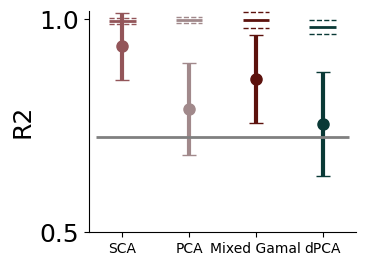

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust axis label colors for better PDF visibility
plt.rcParams['text.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

# General style adjustments
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True

# Define cap size and style
capsize = 5
capstyle = {'linestyle': ':'}

# Create figure
fig, ax = plt.subplots(figsize=(4, 3))

# Add horizontal lines for "all_xxx_recon" mean ± error bars
all_scaR2_recon = np.reshape(allR2_sca, [-1, 1], order='F')
mean_all_sca = np.mean(all_scaR2_recon)
std_all_sca = np.std(all_scaR2_recon)
ax.hlines(mean_all_sca, 0.8, 1.2, color=sca_cMap[0],  lw=2)
ax.hlines([mean_all_sca - std_all_sca, mean_all_sca + std_all_sca], 0.8, 1.2, 
          color=sca_cMap[0], linestyle='--', lw=1)

all_pcaR2_recon = np.reshape(allR2_pca, [-1, 1], order='F')
mean_all_pca = np.mean(all_pcaR2_recon)
std_all_pca = np.std(all_pcaR2_recon)
ax.hlines(mean_all_pca, 1.8, 2.2, color=pca_cMap[0], lw=2)
ax.hlines([mean_all_pca - std_all_pca, mean_all_pca + std_all_pca], 1.8, 2.2, 
          color=pca_cMap[0], linestyle='--', lw=1)

all_mgamalR2_recon = np.reshape(allR2_mgamal, [-1, 1], order='F')
mean_all_mgamal = np.mean(all_mgamalR2_recon)
std_all_mgamal = np.std(all_mgamalR2_recon)
ax.hlines(mean_all_mgamal, 2.8, 3.2, color=mgamal_cMap[-1],  lw=2)
ax.hlines([mean_all_mgamal - std_all_mgamal, mean_all_mgamal + std_all_mgamal], 2.8, 3.2, 
          color=mgamal_cMap[-1], linestyle='--', lw=1)

all_dpcaR2_recon = np.reshape(allR2_dpca, [-1, 1], order='F')
mean_all_dpca = np.mean(all_dpcaR2_recon)
std_all_dpca = np.std(all_dpcaR2_recon)
ax.hlines(mean_all_dpca, 3.8, 4.2, color=dpca_cMap[-1], lw=2)
ax.hlines([mean_all_dpca - std_all_dpca, mean_all_dpca + std_all_dpca], 3.8, 4.2, 
          color=dpca_cMap[-1], linestyle='--', lw=1)

# Plot SCA reconstructions
scaR2_recon = np.reshape(maxR2_sca, [-1, 1], order='F')
ax.errorbar(1, np.mean(scaR2_recon), np.std(scaR2_recon), color=sca_cMap[0], lw=3, capsize=capsize)
ax.plot(1, np.mean(scaR2_recon), 'o', color=sca_cMap[0], ms=8)

# Plot PCA reconstructions
pcaR2_recon = np.reshape(maxR2_pca, [-1, 1], order='F')
ax.errorbar(2, np.mean(pcaR2_recon), np.std(pcaR2_recon), color=pca_cMap[0], lw=3, capsize=capsize)
ax.plot(2, np.mean(pcaR2_recon), 'o', color=pca_cMap[0], ms=8)

# Plot Mixed Gamal reconstructions
mgamalR2_recon = np.reshape(maxR2_mgamal, [-1, 1], order='F')
ax.errorbar(3, np.mean(mgamalR2_recon), np.std(mgamalR2_recon), color=mgamal_cMap[-1], lw=3, capsize=capsize)
ax.plot(3, np.mean(mgamalR2_recon), 'o', color=mgamal_cMap[-1], ms=8)


# Plot dPCA reconstructions
dpcaR2_recon = np.reshape(maxR2_dpca, [-1, 1], order='F')
ax.errorbar(4, np.mean(dpcaR2_recon), np.std(dpcaR2_recon), color=dpca_cMap[-1], lw=3, capsize=capsize)
ax.plot(4, np.mean(dpcaR2_recon), 'o', color=dpca_cMap[-1], ms=8)

# Final plot adjustments
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0.5, 1.02)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['SCA', 'PCA', 'Mixed Gamal','dPCA'],size=10)
ax.set_yticks([0.5, 1.0])
ax.set_ylabel('R2')

# Remove border around figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot baseline: random rotations of PCA latents
rotR2_recon = np.reshape(maxR2_pca_rotate, [-1, 1], order='F')
mean_rot = np.mean(rotR2_recon)
std_rot  = np.std(rotR2_recon)
ax.hlines(mean_rot, 0.6, 4.4, color='gray', lw=2, linestyle='-')
# ax.hlines([mean_rot - std_rot, mean_rot + std_rot], 0.6, 4.4,
#           color='gray', linestyle='--', lw=1)

# # # save directory
figDir = '/Users/sherryan/sca/sca_analysis/'

# # save
plt.savefig(figDir + monkName + '_r2_dist.pdf', dpi = 'figure')
plt.tight_layout()
plt.show()

In [13]:
mean_rot

0.7238000615831802

In [ ]:
# difference in recon R2 using single behavior (maxR2)
r2meanDiff = [np.mean(maxR2_sca[i,:])-np.mean(maxR2_pca[i,:]) for i in range(100)]
prop = sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs PCA',prop)

r2meanDiff = [np.mean(maxR2_sca[i,:])-np.mean(maxR2_mgamal[i,:]) for i in range(100)]
prop = sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs mixed Gamal',prop)

r2meanDiff = [np.mean(maxR2_sca[i,:])-np.mean(maxR2_dpca[i,:]) for i in range(100)]
prop = sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs dPCA',prop)

In [ ]:
# difference in recon R2, between using all vs. single behavior (allR2 - maxR2)
r2meanDiff = [np.mean(allR2_sca[i,:]-maxR2_sca[i,:])-np.mean(allR2_pca[i,:]-maxR2_pca[i,:]) for i in range(100)]
prop = 1-sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs PCA',prop)

r2meanDiff = [np.mean(allR2_sca[i,:]-maxR2_sca[i,:])-np.mean(allR2_mgamal[i,:]-maxR2_mgamal[i,:]) for i in range(100)]
prop = 1-sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs mixed Gamal',prop)

r2meanDiff = [np.mean(allR2_sca[i,:]-maxR2_sca[i,:])-np.mean(allR2_dpca[i,:]-maxR2_dpca[i,:]) for i in range(100)]
prop = 1-sum(1 for i in r2meanDiff if i > 0)/len(r2meanDiff)
print('SCA vs dPCA',prop)